In [2]:
import glob
import netCDF4 as nc
import shapefile
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import xarray as xr

In [3]:
#Read the shapefile and one ELM output
WS_shp = '/global/homes/f/fzahura/watershed/AmericanRiver.shp'
nc_elm = nc.Dataset('/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.2000-01-01-00000.nc')


In [4]:
nc_elm_xr = xr.open_dataset('/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.2000-01-01-00000.nc')


In [5]:
nc_elm_xr

<xarray.Dataset>
Dimensions:       (levgrnd: 15, levlak: 10, levdcmp: 15, levsoi: 10, time: 1,
                   hist_interval: 2, lndgrid: 1175)
Coordinates:
  * levgrnd       (levgrnd) float32 0.007101 0.02792 0.06226 ... 21.33 35.18
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.007101 0.02792 0.06226 ... 21.33 35.18
  * levsoi        (levsoi) float32 0.007101 0.02792 0.06226 ... 1.728 2.865
  * time          (time) object 2000-01-01 00:00:00
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/35)
    mcdate        (time) int32 ...
    mcsec         (time) int32 ...
    mdcur         (time) int32 ...
    mscur         (time) int32 ...
    nstep         (time) int32 ...
    time_bounds   (time, hist_interval) object ...
    ...            ...
    QINTR         (time, lndgrid) float32 ...
    QOVER         (time, lndgrid) float32 ...
    QRUNOFF       (time, lndgrid) float32 ...
    QSOIL         (time, lndgrid) float32 ...
    QVEGE         (time, lndgrid) float32 ...
    QVEGT         (time, lndgrid) float32 ...
Attributes: (12/27)
    title:                                     ELM History file information
    source:                                    E3SM Land Model
    source_id:                                 b30a6a0cb3
    product:                                   model-output
    realm:                                     land
    case:                                      I20TRCNPRDCTCBC.NLDAS.1175.NTA...
    ...                                        ...
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9

### Get the indeces from the netcdf that are inside the watershed boundary

In [6]:
lat = nc_elm.variables['lat'][:]
lon = nc_elm.variables['lon'][:]
print(lat,lon)

[46.804165 46.804165 46.804165 ... 47.004166 47.004166 47.004166] [238.47084 238.47917 238.4875  ... 238.8375  238.84584 238.85417]


In [7]:
sf = shapefile.Reader(WS_shp)
shapes = sf.shapes()
lon_shp = [[],[],[]]
lat_shp =[[],[],[]]
polygons_list = []
for shape,i in zip(shapes,range(len(shapes))):
    # print(shape,i)
    polygons_list.append(shape)
    for vertex in shape.points:
        print(vertex)
        #Adding 360 to lon because lon values in the shapefile ranges -180 to 180,
        #while in netcdf the values range 0 to 360
        lon_shp[i].append(vertex[0]+360)
        lat_shp[i].append(vertex[1])  


(-121.36243841164497, 46.96125112189833)
(-121.36237909185337, 46.960628934399324)
(-121.36233965956177, 46.96021169481662)
(-121.36234692206176, 46.959973698983674)
(-121.36235346164506, 46.959759500025655)
(-121.36236399289504, 46.95941440419284)
(-121.36237162102003, 46.95916450835989)
(-121.36236295539504, 46.95887866252701)
(-121.36228767310354, 46.95849662294427)
(-121.36224098247857, 46.95831738127788)
(-121.36220716268696, 46.9581971094031)
(-121.36220899185366, 46.95817824898643)
(-121.36221670435361, 46.95809630002822)
(-121.36220276789533, 46.957902390653544)
(-121.36220207310367, 46.95789272607021)
(-121.36220337935367, 46.95784993127859)
(-121.36218428664534, 46.95779257086201)
(-121.36215987518705, 46.95773870523709)
(-121.36213426789544, 46.957694505237214)
(-121.36208751685382, 46.957648501070594)
(-121.36193473039572, 46.957527263570796)
(-121.36185146268753, 46.95740702190432)
(-121.3617363418544, 46.957191084404656)
(-121.3616541637295, 46.957035141696565)
(-121.3615

In [8]:
#Create polygons using the shape vertices and points for lat/lon of netcdf grids.
#check if the point is inside the polygon and store in a list
lat_lon_in = []
for i in range(len(shapes)):
    for lon_w,lat_w in zip(lon,lat):
        lons_lats_vect = np.column_stack((lon_shp[i], lat_shp[i]))
        polygon = Polygon(lons_lats_vect) 
        point = Point(lon_w,lat_w)
        if  polygon.contains(point)==True:
            lat_lon_in.append([lon_w,lat_w])
            # lat_lon_in.append([lon_w-360,lat_w])
lon_in = []
lat_in =[]
for k,l in zip(nc_elm.variables['lon'][:],nc_elm.variables['lat'][:]):
    # print([k,l])
    if [k,l] in lat_lon_in:
        lon_in.append(k)
        lat_in.append(l)

In [9]:
#get indexes of grids inside polygon
grids_in_poly = []
for k,l in zip(lon_in,lat_in):
    indx = np.where((nc_elm.variables['lon'][:] == k) & (nc_elm.variables['lat'][:] == l))
    if len(indx[0])>0:
        # print(indx)
        grids_in_poly.append(indx[0][0])
lon_elm_in =nc_elm.variables['lon'][grids_in_poly]
lat_elm_in = nc_elm.variables['lat'][grids_in_poly]
print(len(lon_elm_in))

347


In [10]:
grids_in_poly

[101,
 102,
 103,
 104,
 148,
 149,
 150,
 151,
 194,
 195,
 196,
 197,
 198,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 287,
 288,
 289,
 290,
 291,
 292,
 293,
 294,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 398,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 443,
 444,
 445,
 446,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 490,
 491,
 492,
 493,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 537,
 538,
 539,
 540,
 568,
 569,
 570,
 571,
 572,
 573,
 574,
 575,
 576,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 587,
 588,
 617,
 618,
 619,
 620,
 621,
 622,
 623,
 624,
 625,
 626,
 627,
 628,
 629,
 630,
 631,
 632,
 633,
 634,
 635,
 636,
 637,
 666,
 667,
 668,
 669,
 670,
 671,
 672

#### Get the min and max values across all the output netcdfs for each variable of interest to have consistent colorbar

In [11]:
#get max and min values for each netcdf
qsoil_max = []
qsoil_min = []
qvege_max = []
qvege_min = []
qvegt_max = []
qvegt_min = []
qover_max = []
qover_min = []

nc_list = glob.glob('/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.*.nc')
for f in nc_list:
    print(f)
    ds = nc.Dataset(f)
    qsoil_max.append(np.nanmax(ds['QSOIL'][:]))
    qsoil_min.append(np.nanmin(ds['QSOIL'][:]))
    
    qvege_max.append(np.nanmax(ds['QVEGE'][:]))
    qvege_min.append(np.nanmin(ds['QVEGE'][:]))
    
    qvegt_max.append(np.nanmax(ds['QVEGT'][:]))
    qvegt_min.append(np.nanmin(ds['QVEGT'][:]))
    
    qover_max.append(np.nanmax(ds['QOVER'][:]))
    qover_min.append(np.nanmin(ds['QOVER'][:]))
    


/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.2014-12-01-00000.nc
/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.2017-07-26-00000.nc
/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.2006-08-08-00000.nc
/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.2015-04-09-00000.nc
/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.2003-01-30-00000.nc
/pscratch/sd/f/fzahura/e3sm_scratch/pm-c

In [12]:
#max and min for all netcdf
var2_max_w = np.max(qsoil_max)
var2_min_w = np.min(qsoil_min)
var3_max_w = np.max(qvege_max)
var3_min_w = np.min(qvege_min)
var4_max_w = np.max(qvegt_max)
var4_min_w = np.min(qvegt_min)
var1_max_w = np.max(qover_max)
var1_min_w = np.min(qover_min)

#### Plotting (spatial) daily values for grids in watershed

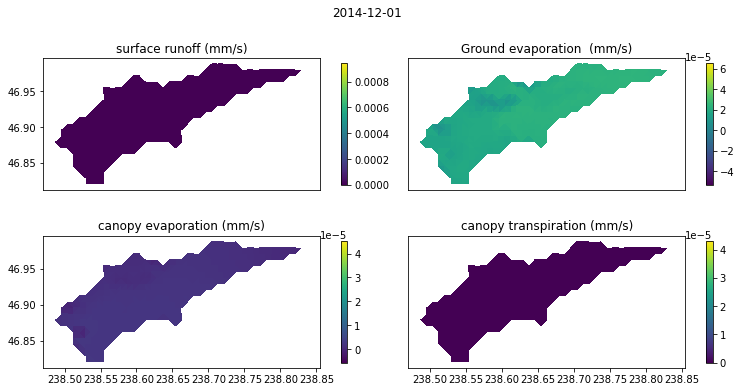

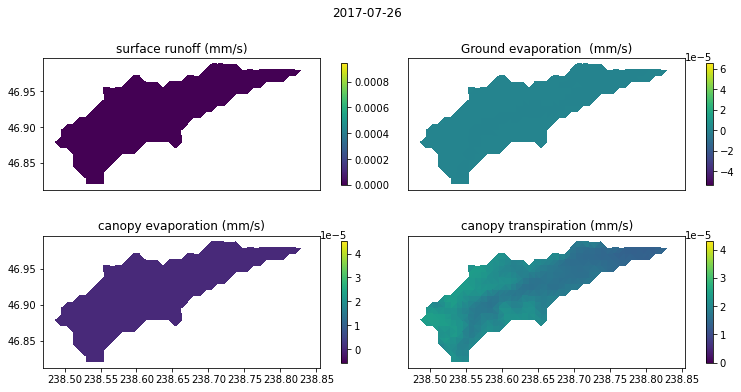

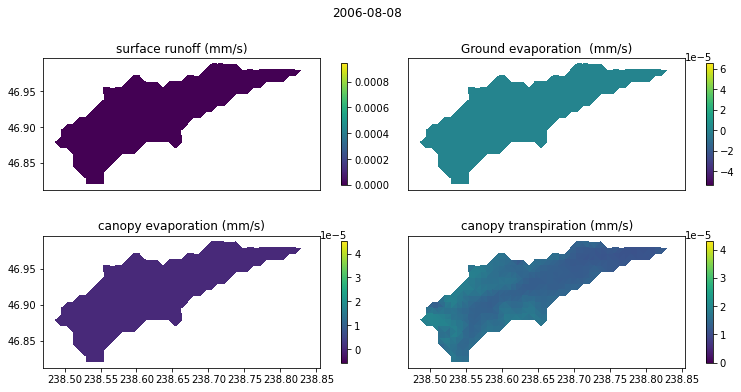

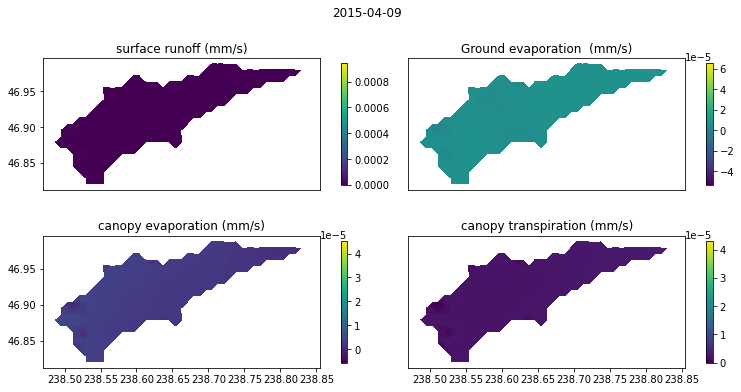

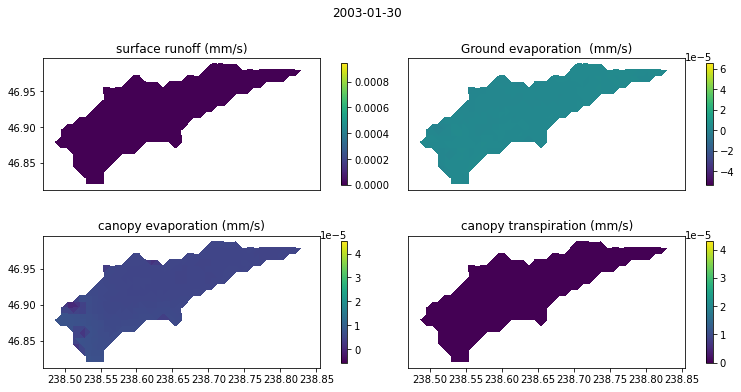

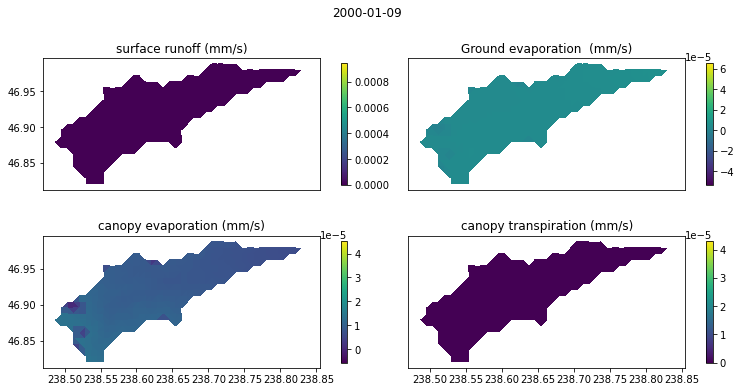

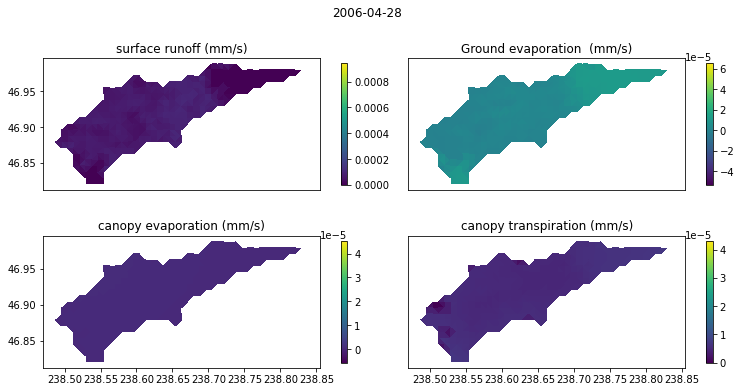

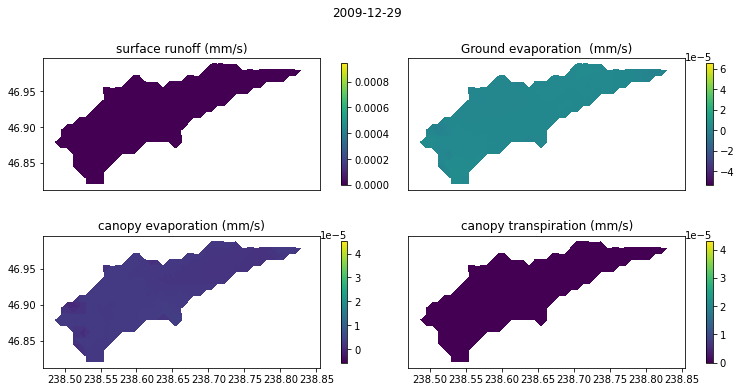

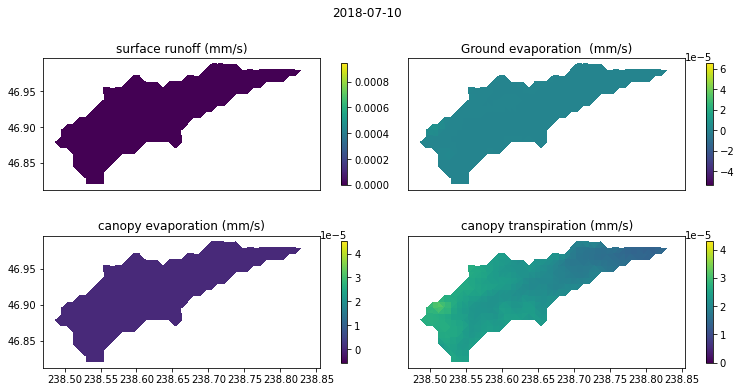

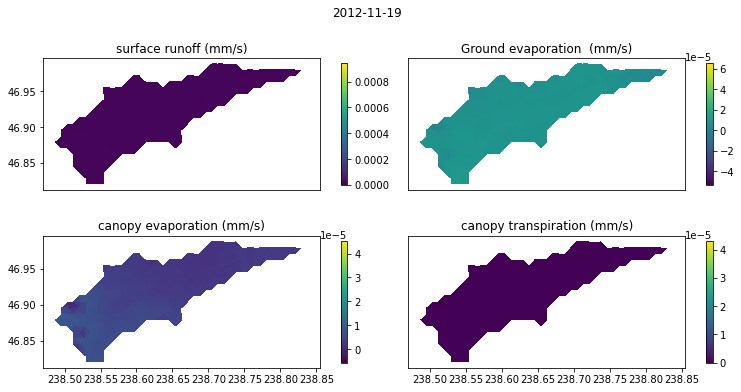

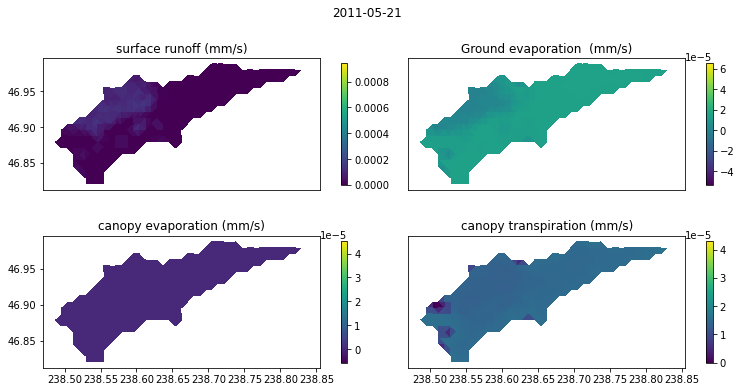

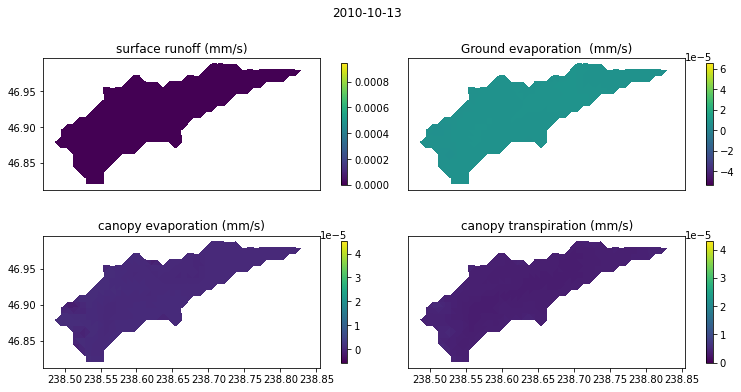

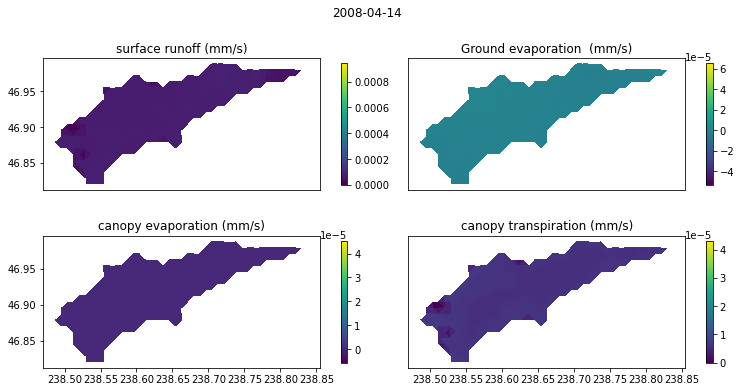

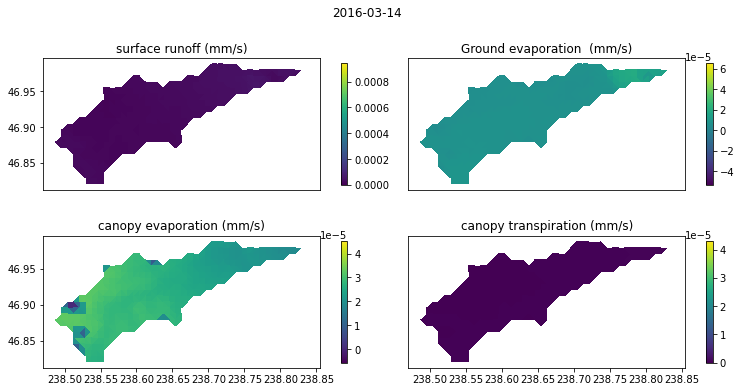

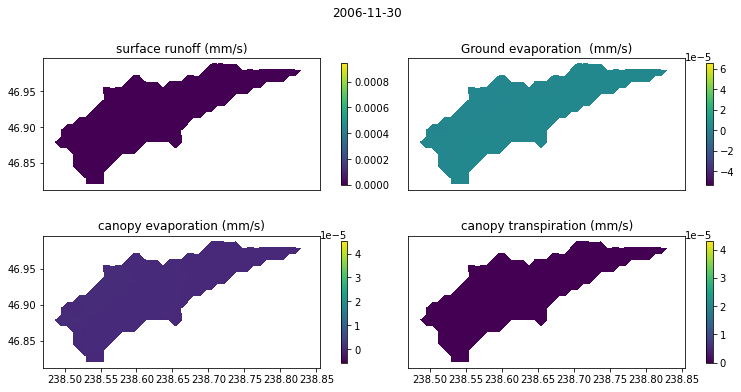

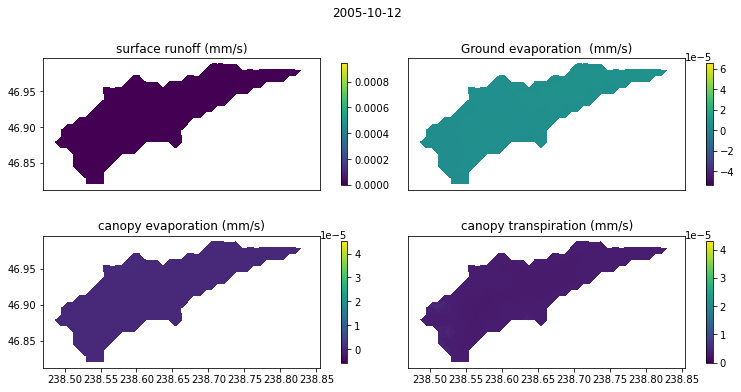

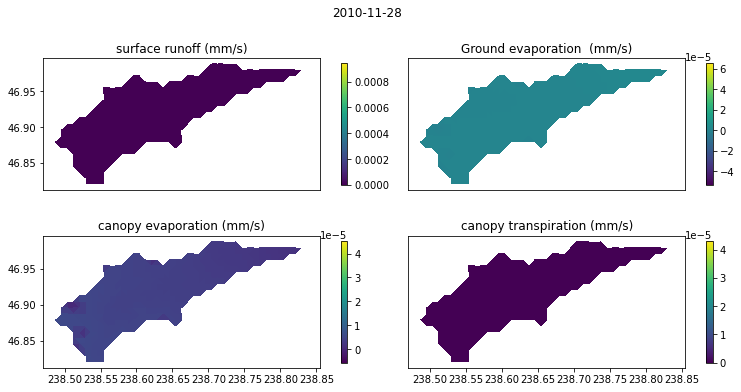

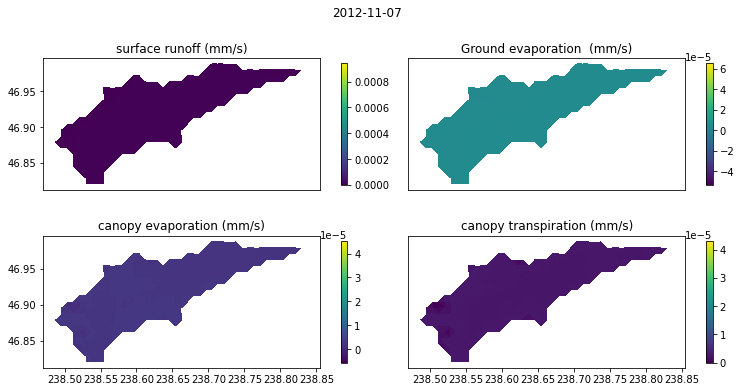

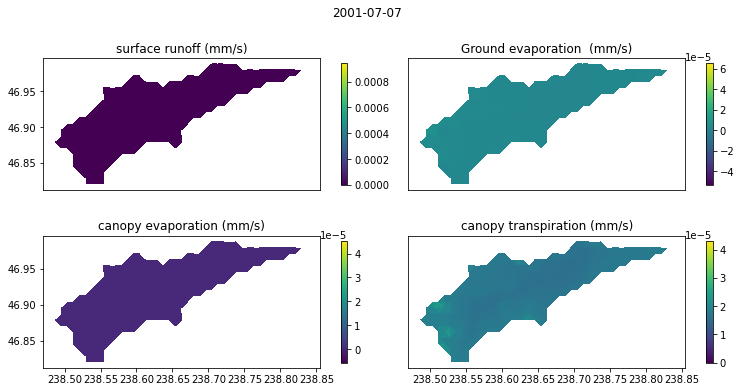

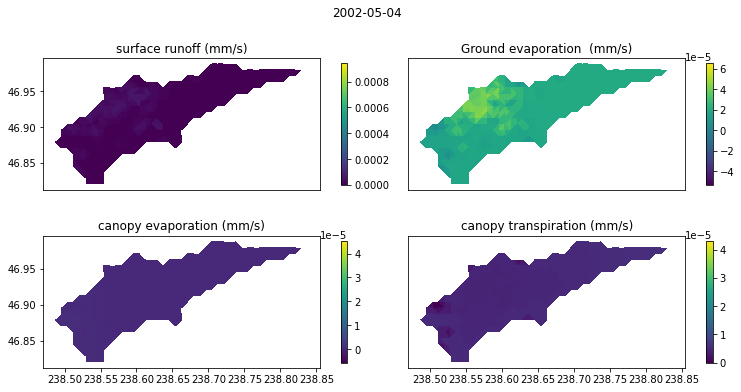

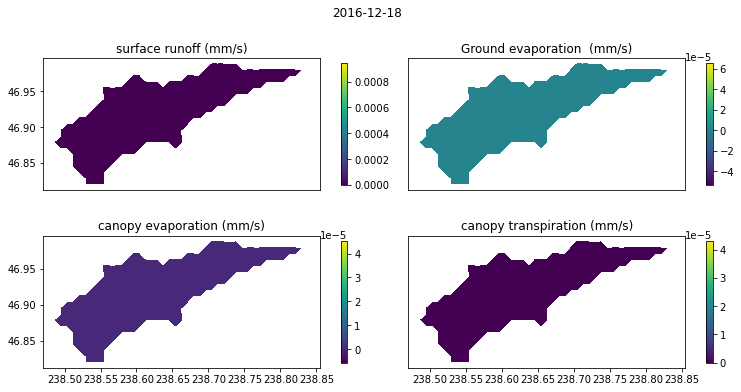

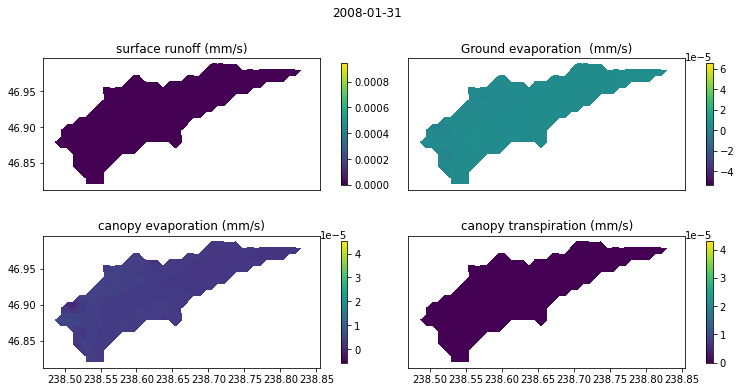

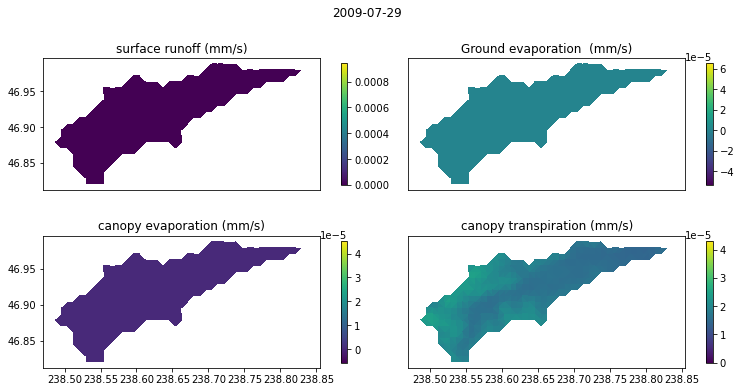

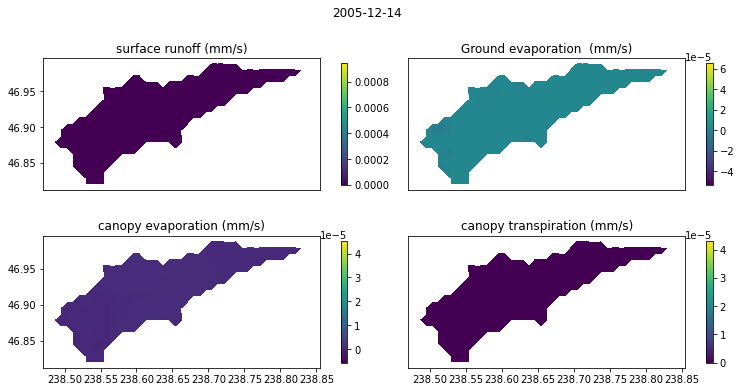

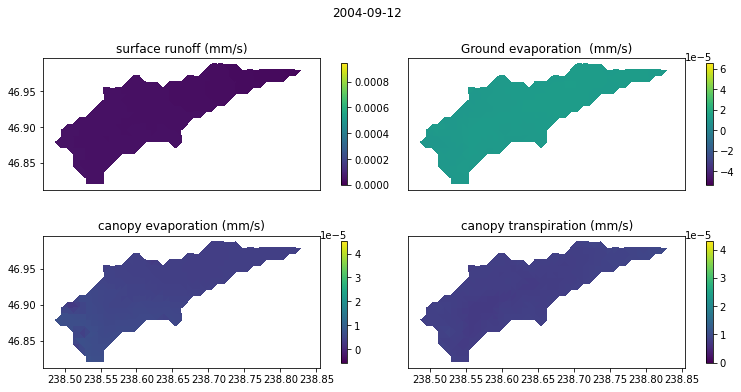

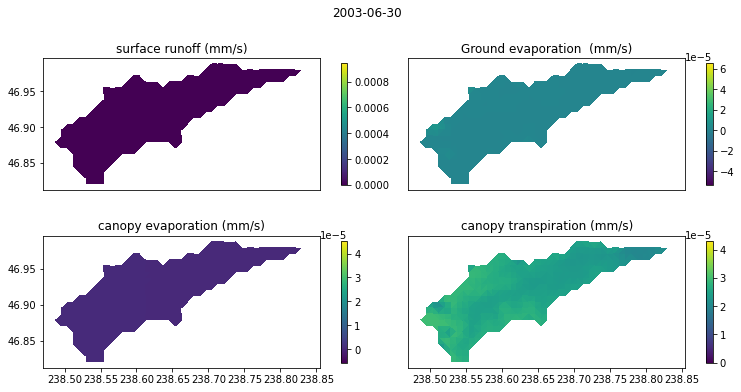

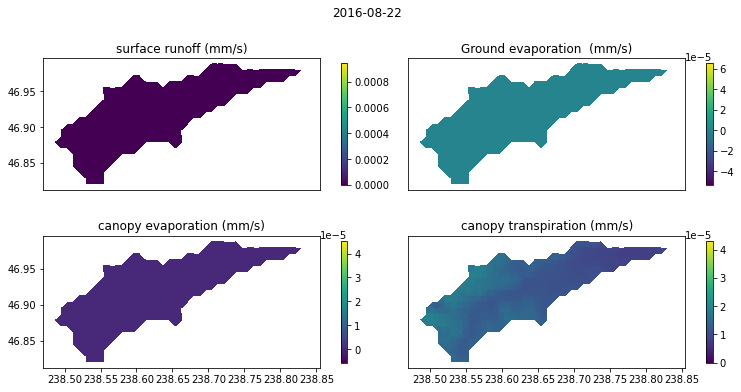

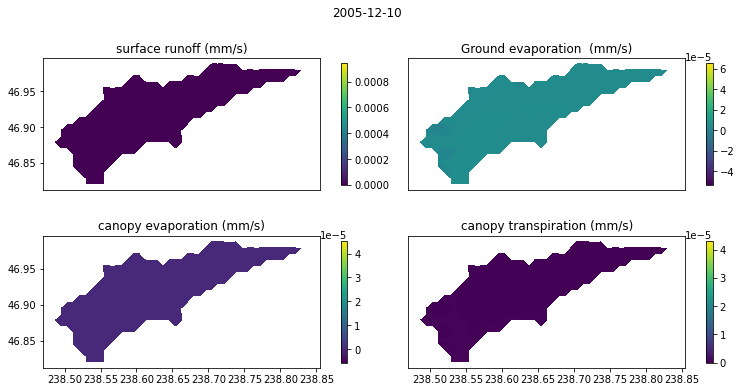

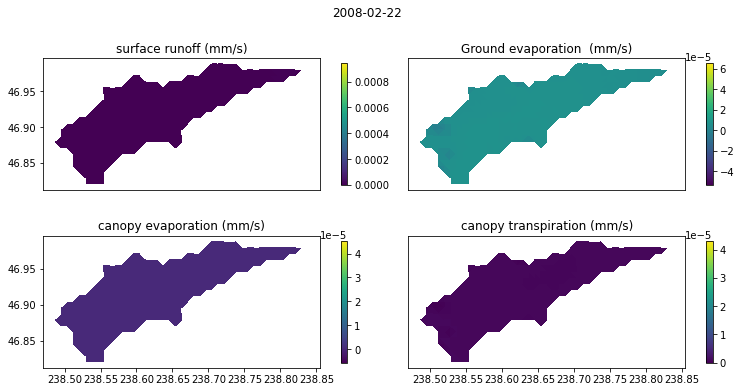

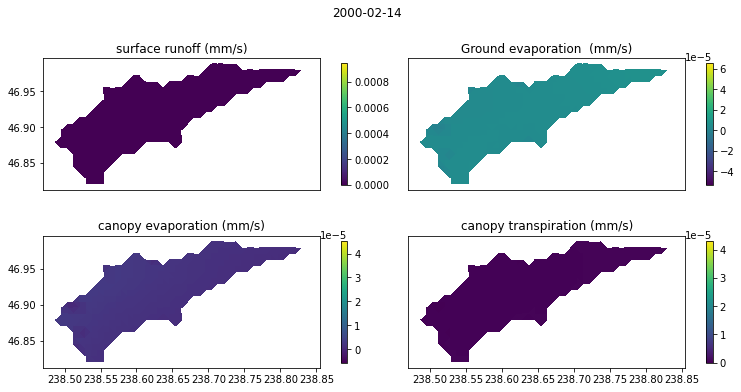

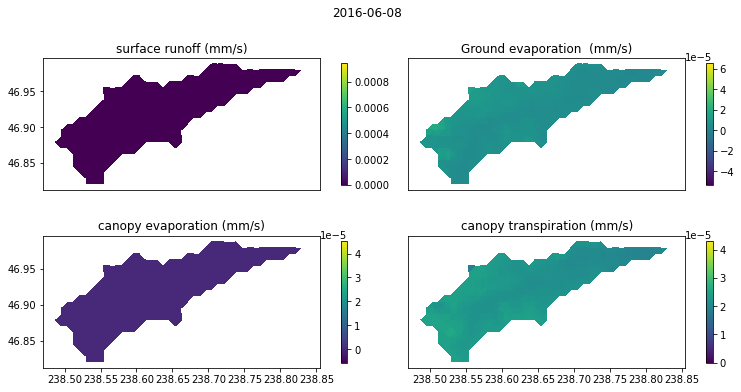

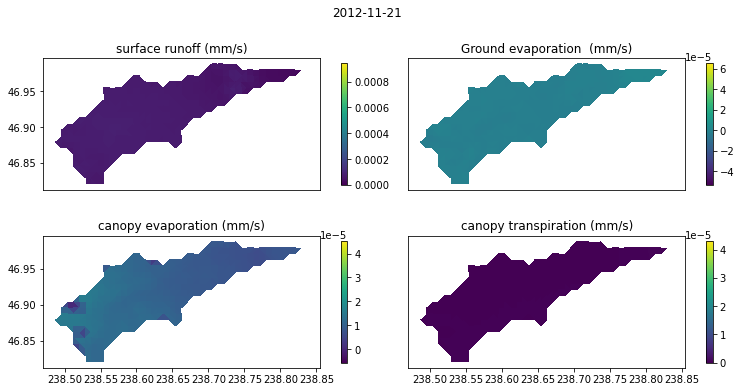

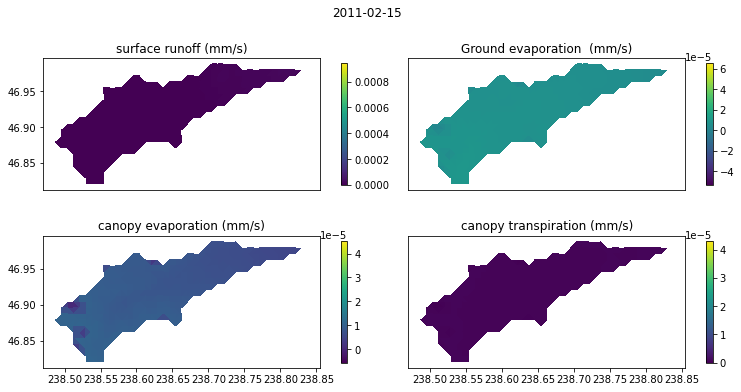

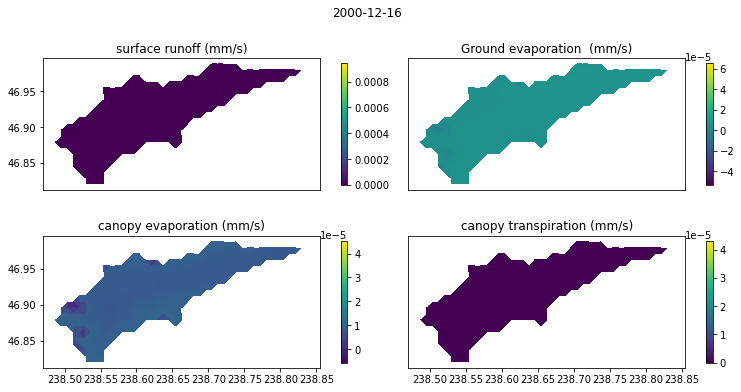

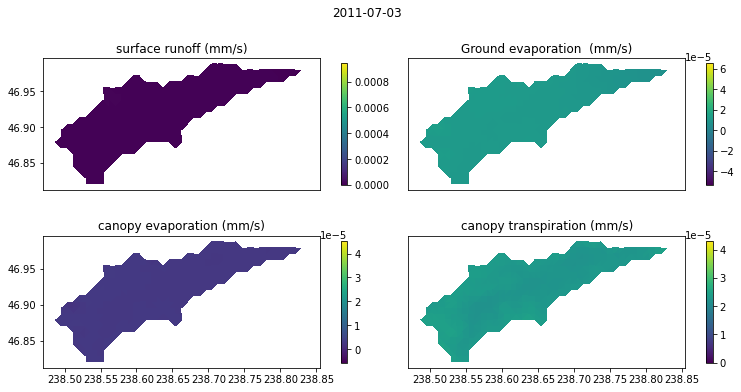

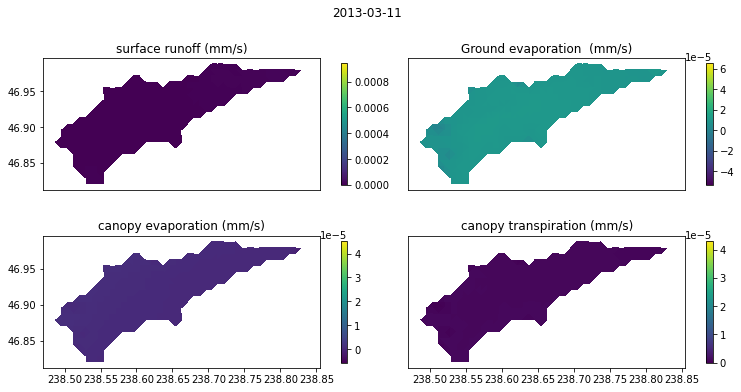

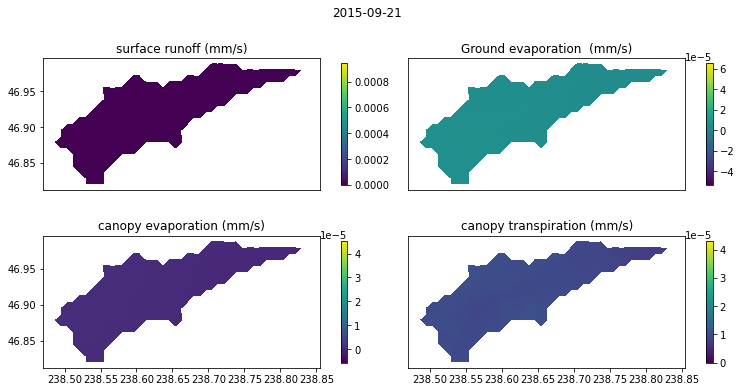

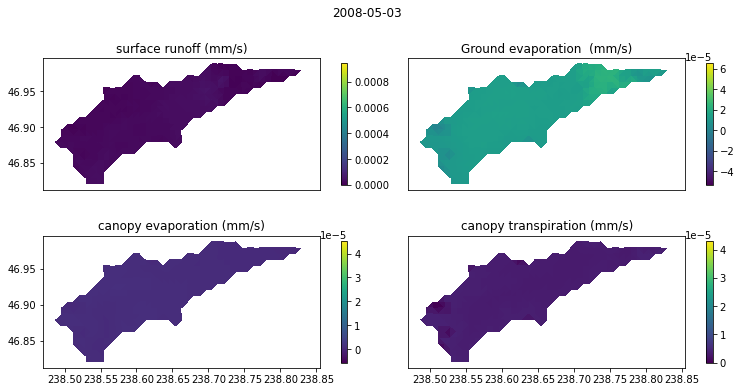

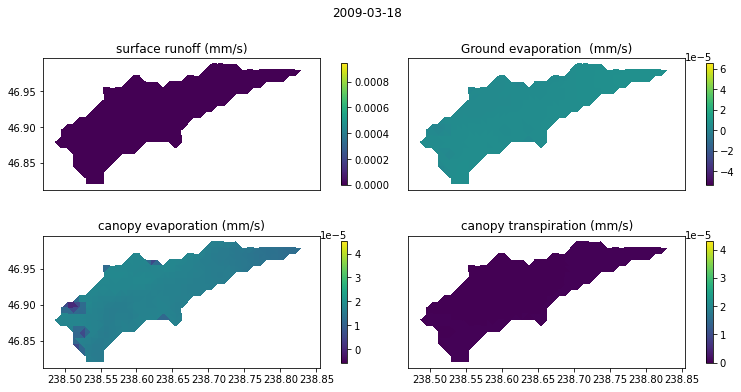

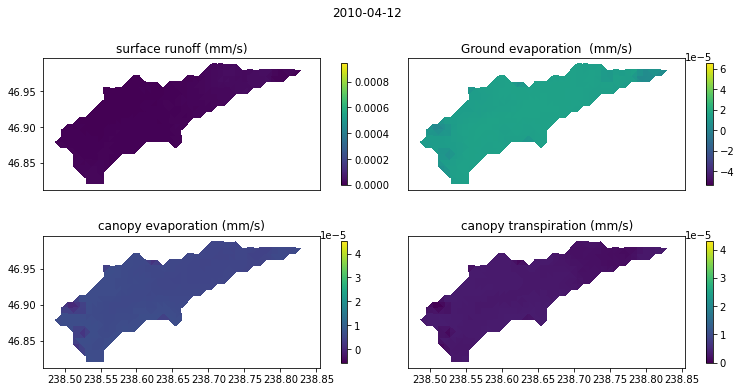

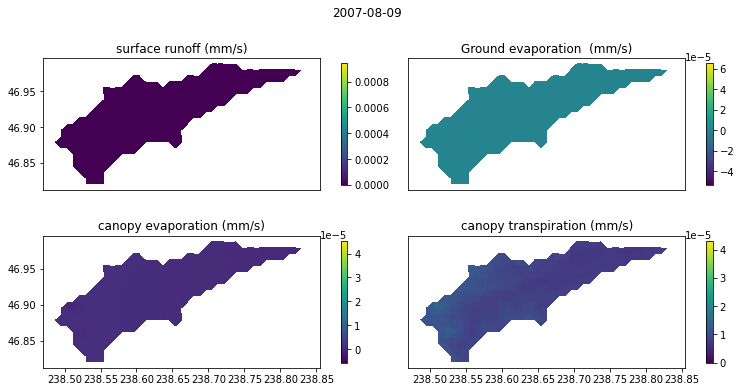

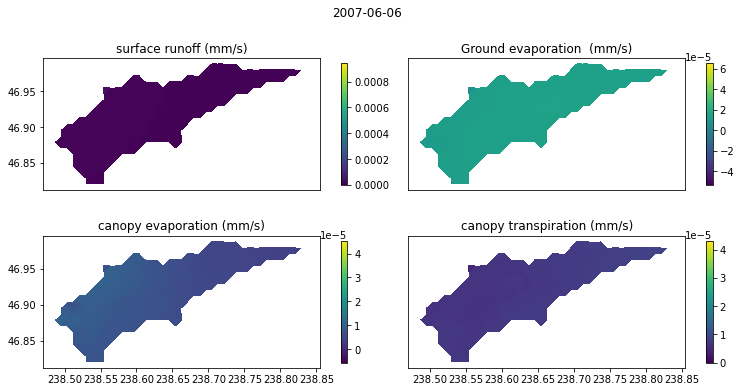

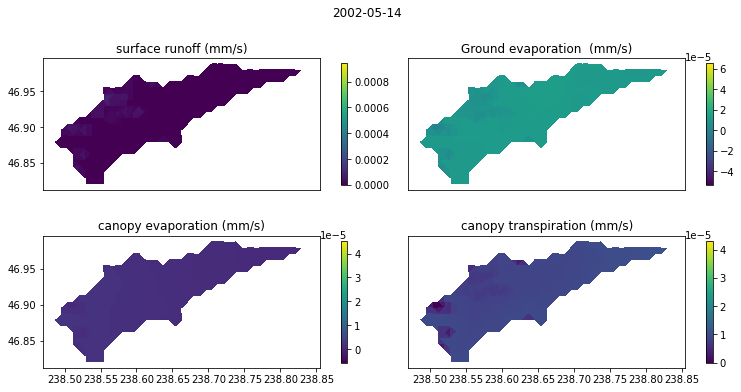

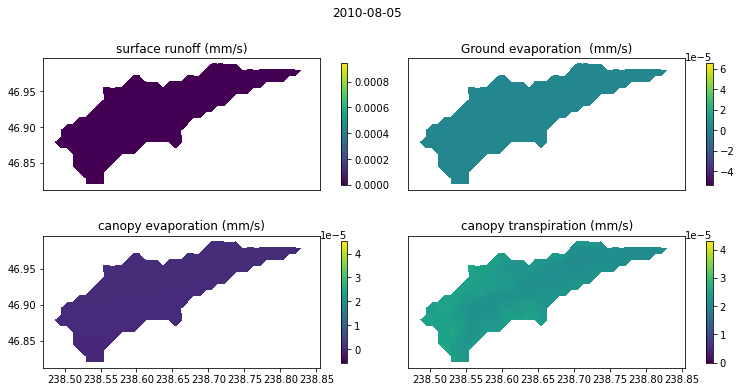

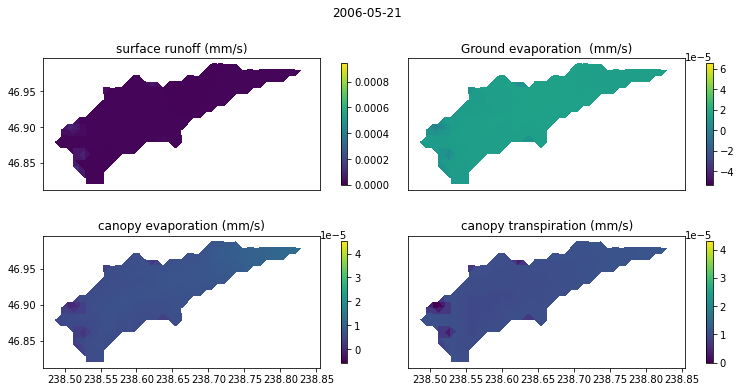

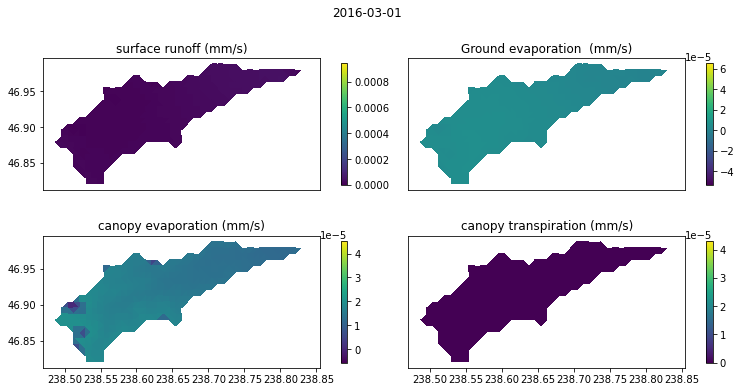

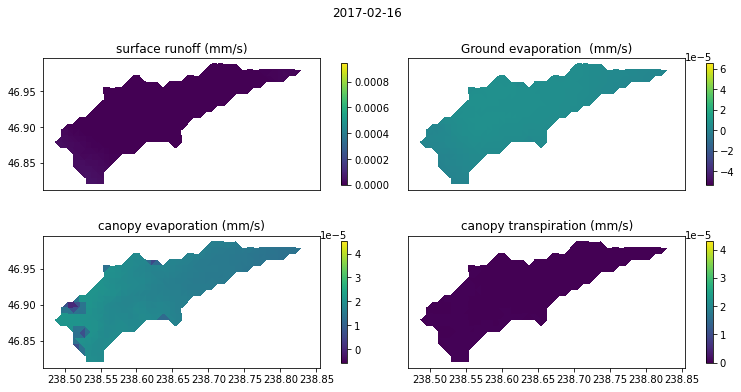

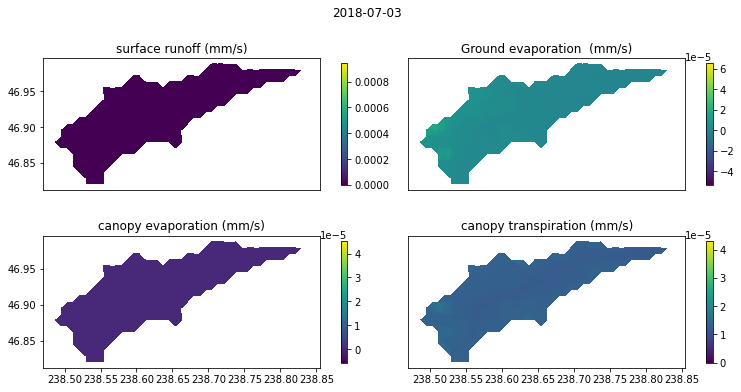

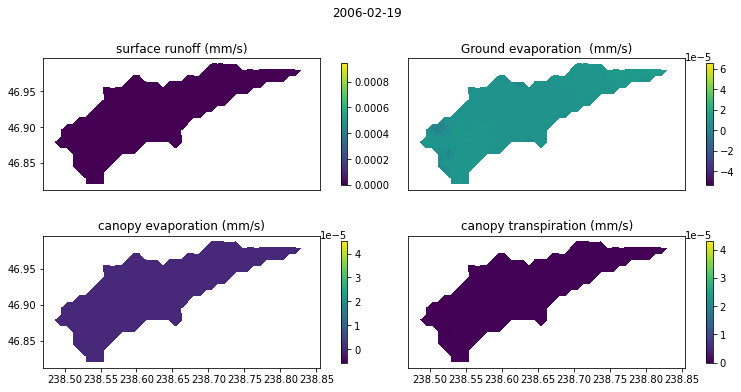

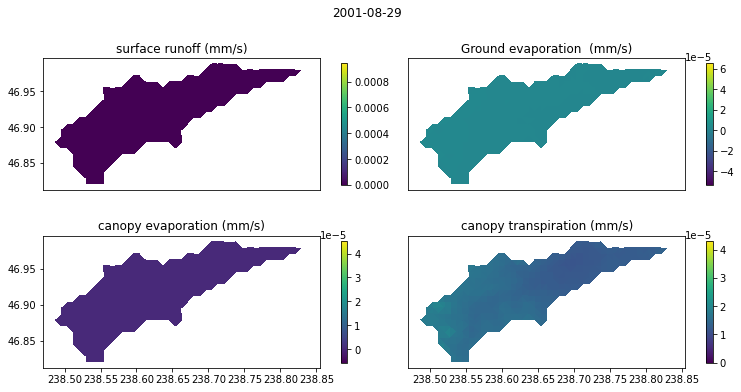

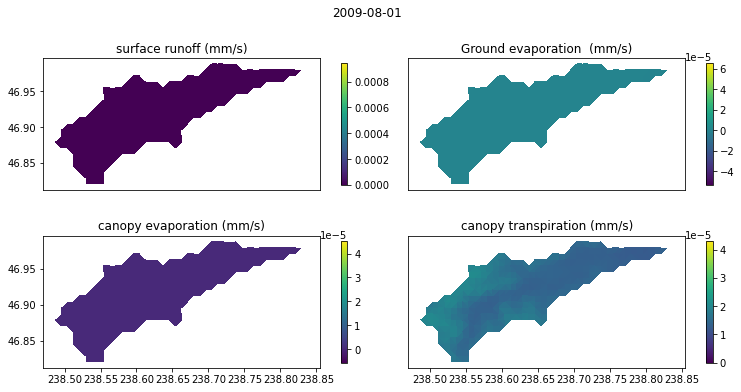

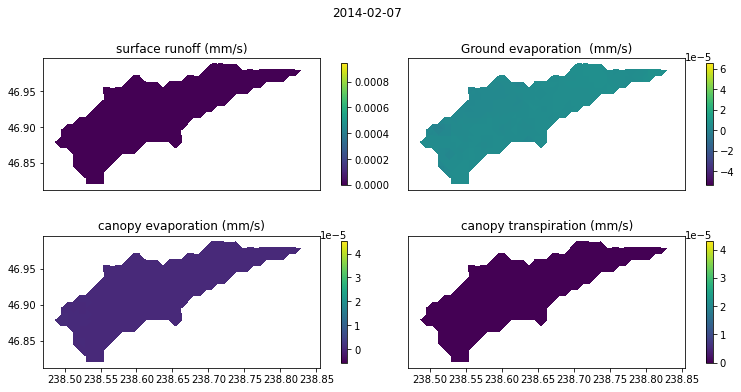

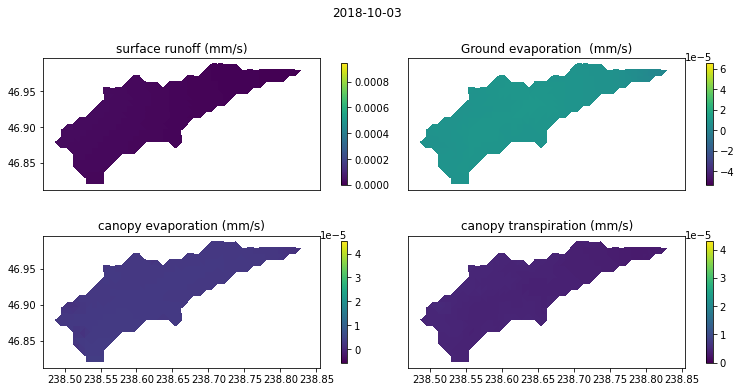

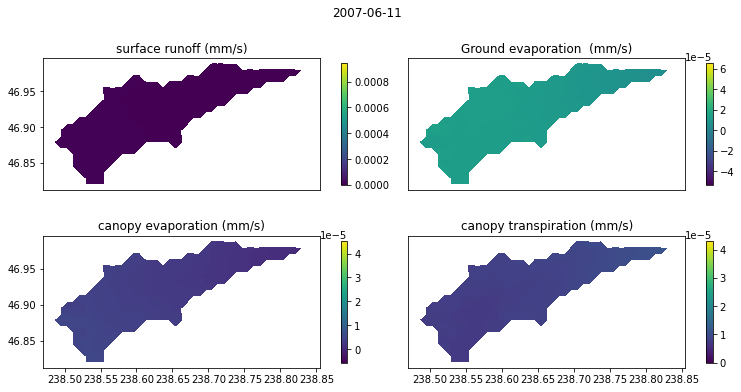

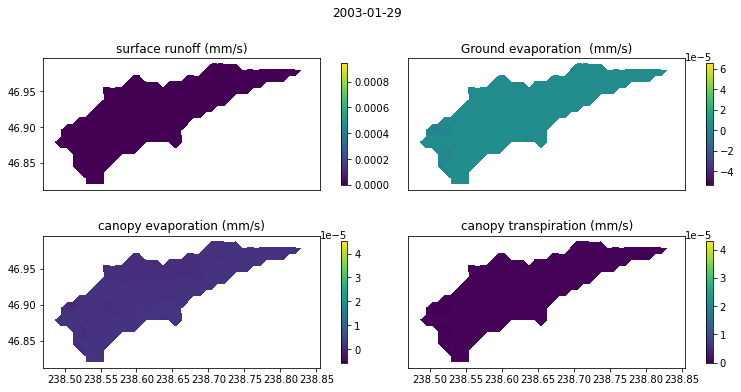

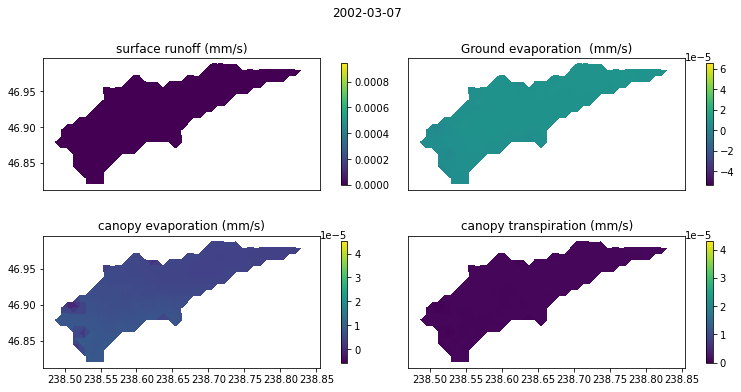

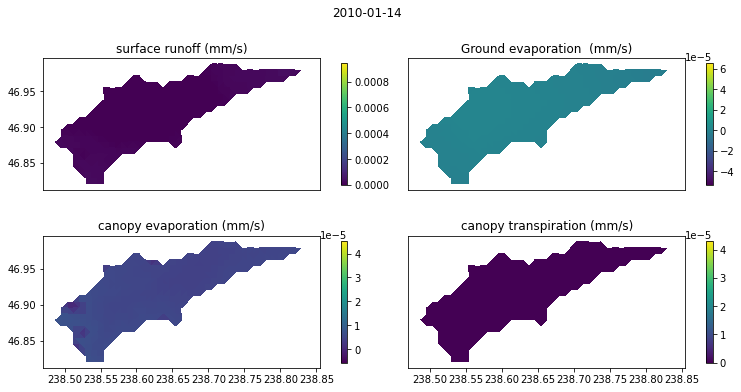

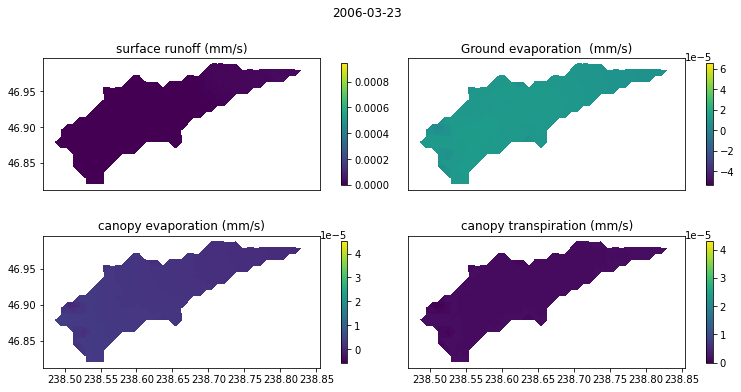

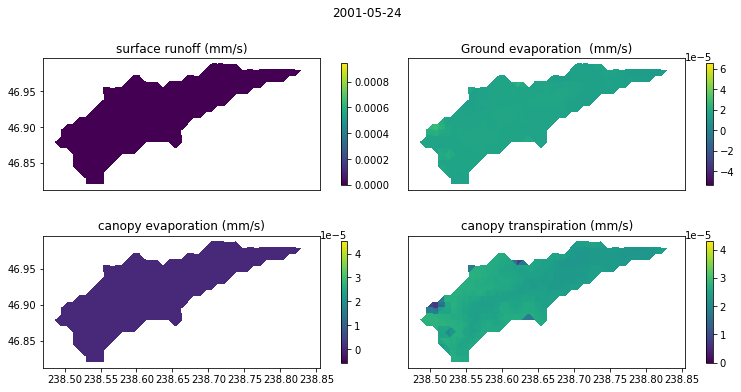

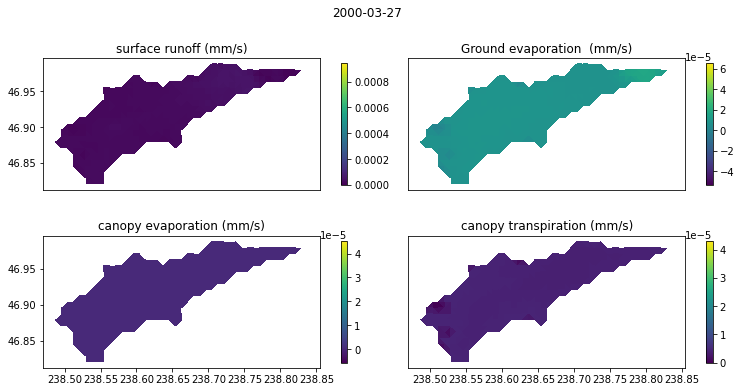

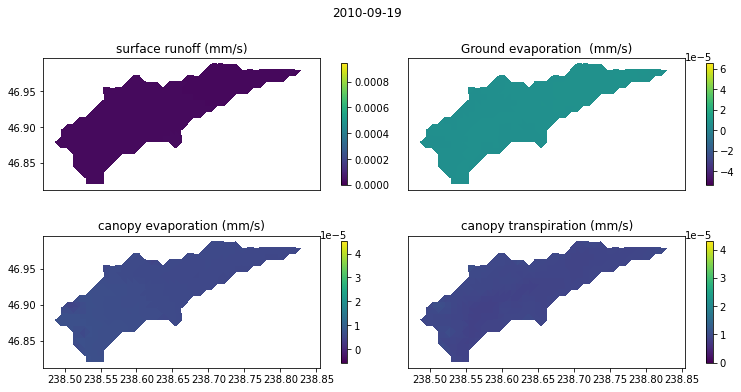

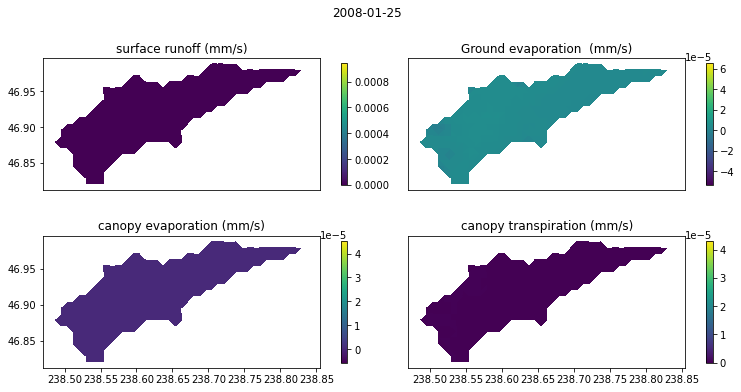

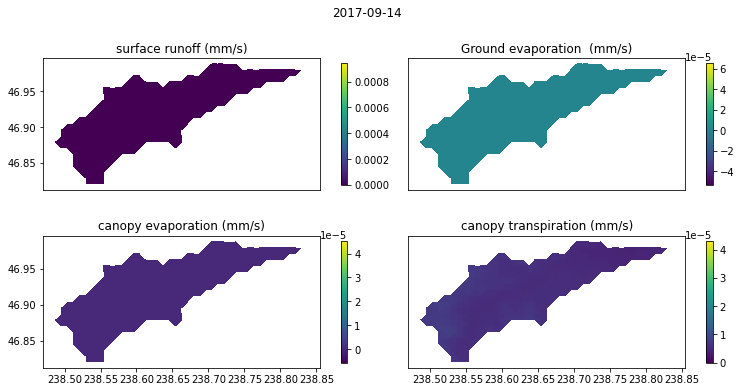

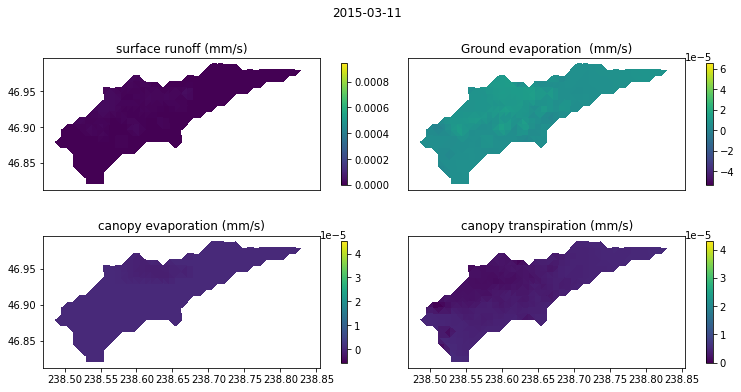

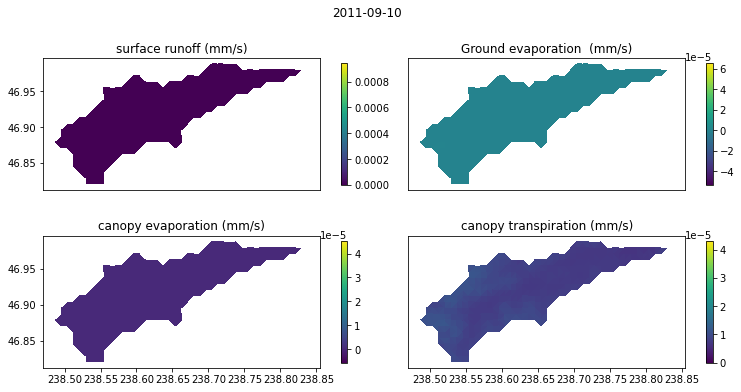

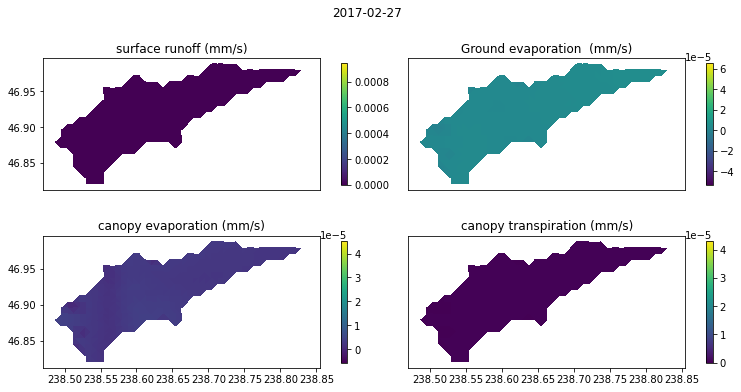

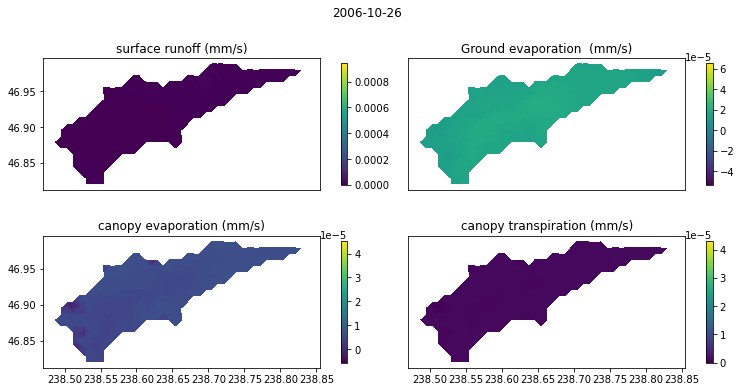

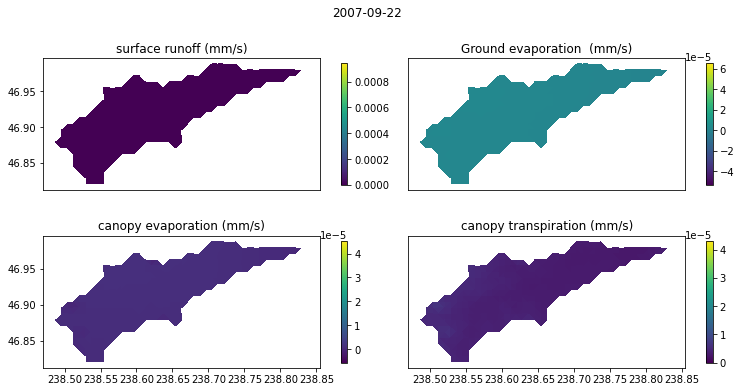

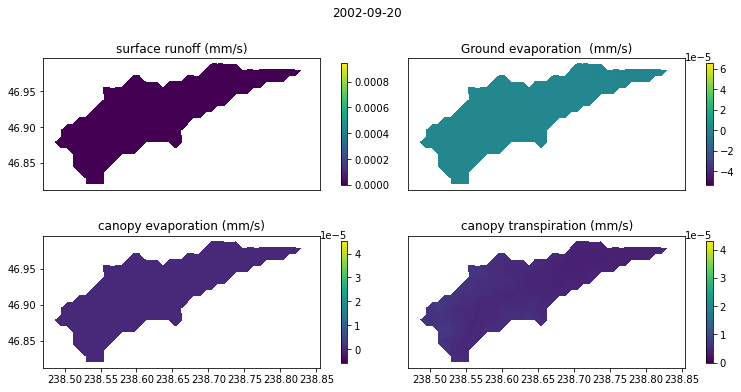

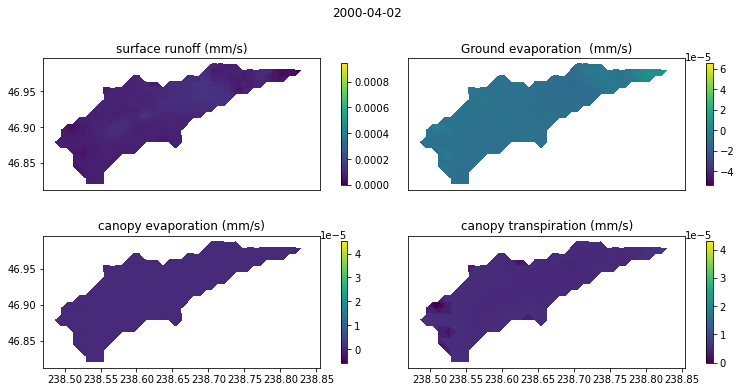

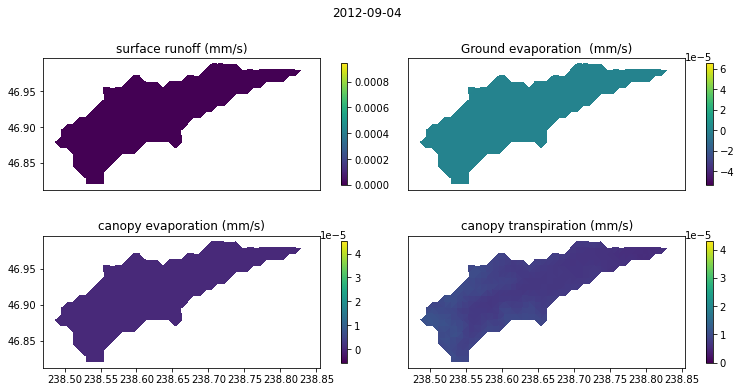

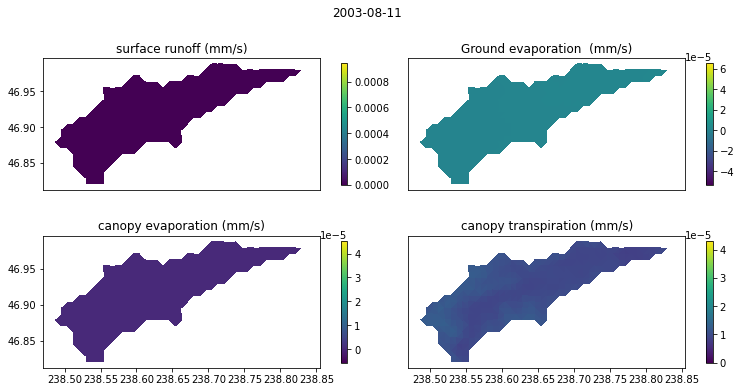

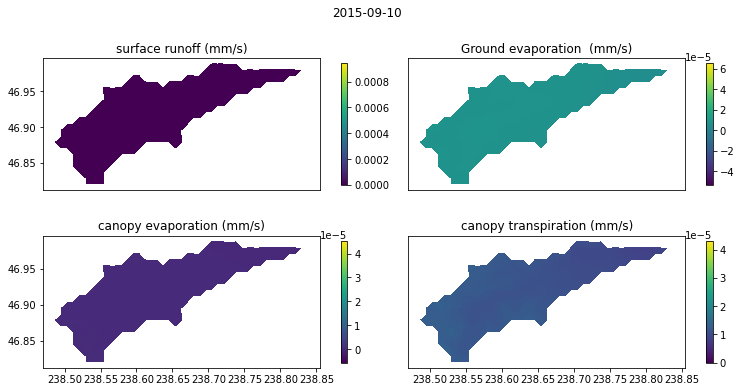

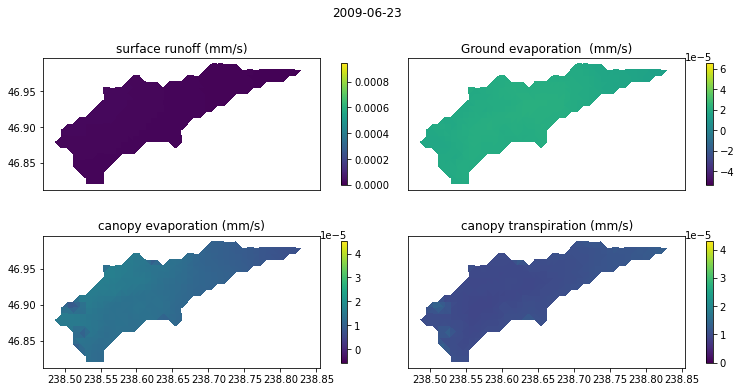

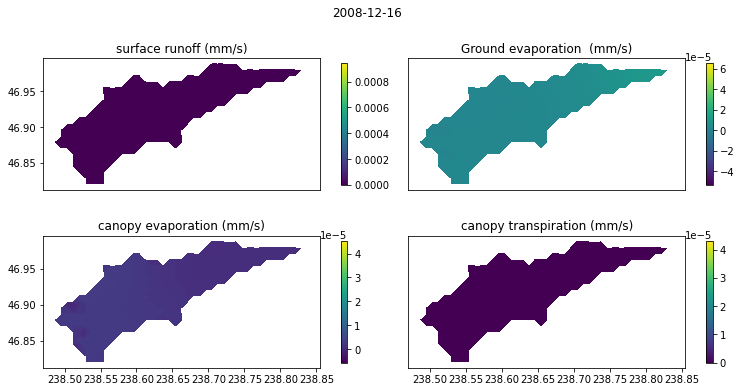

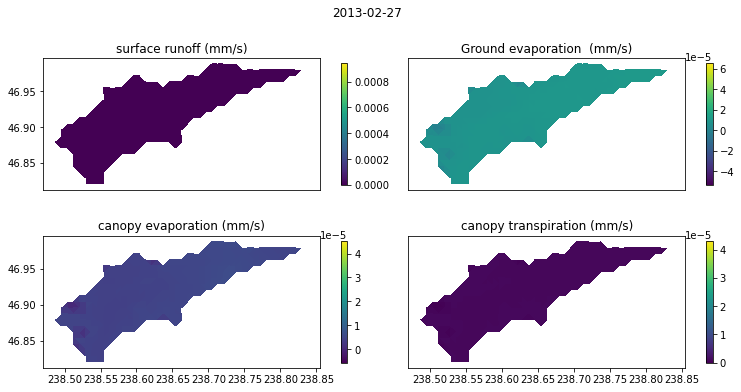

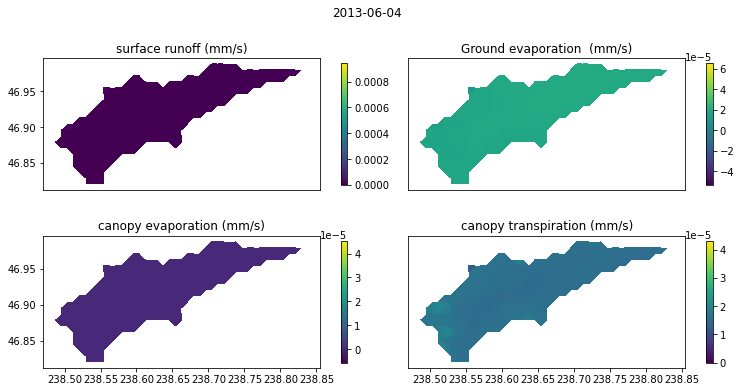

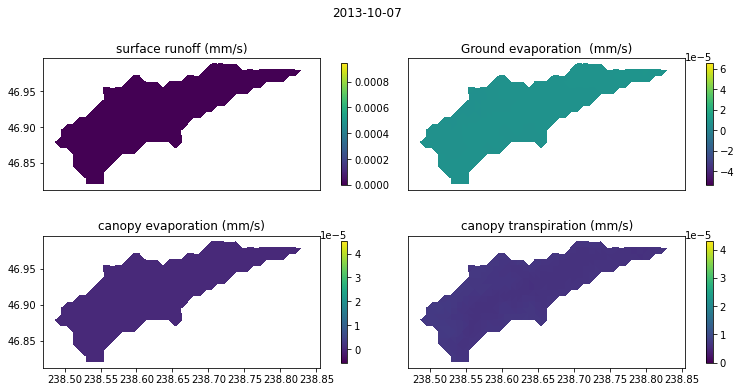

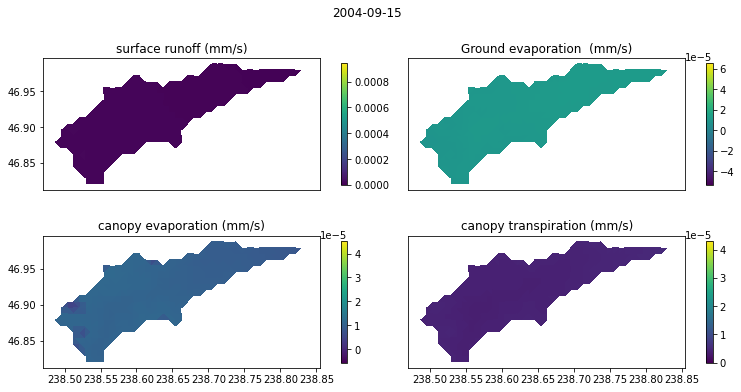

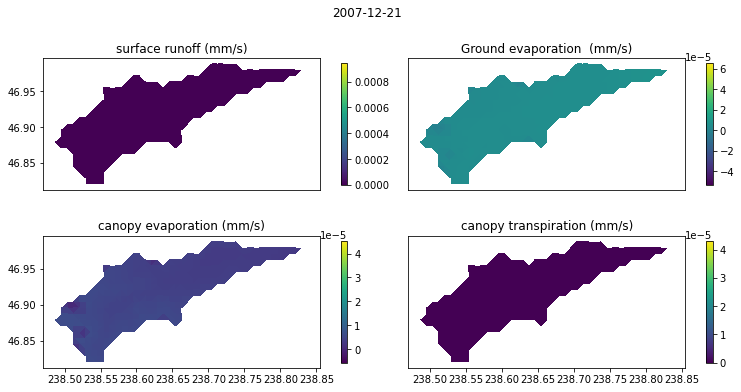

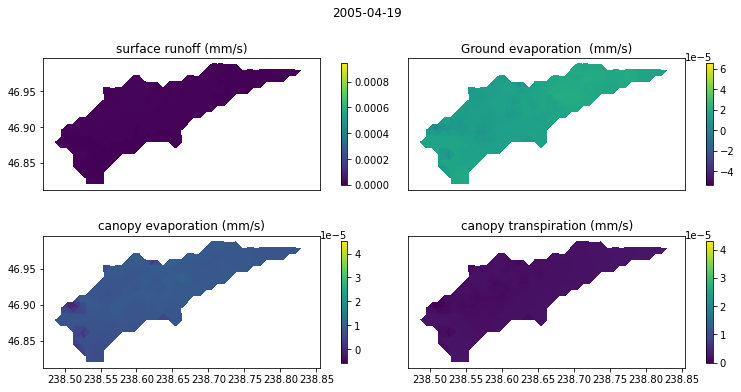

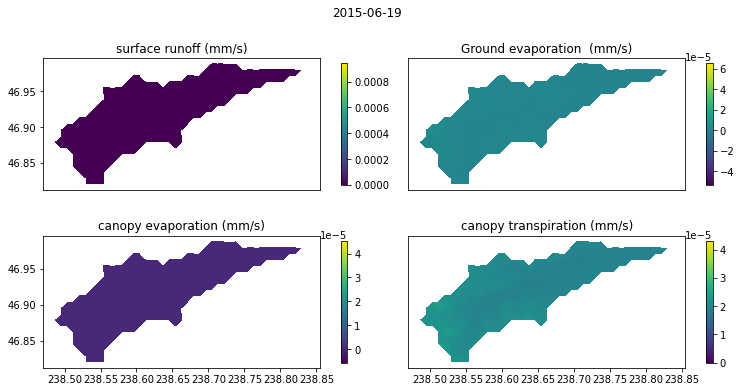

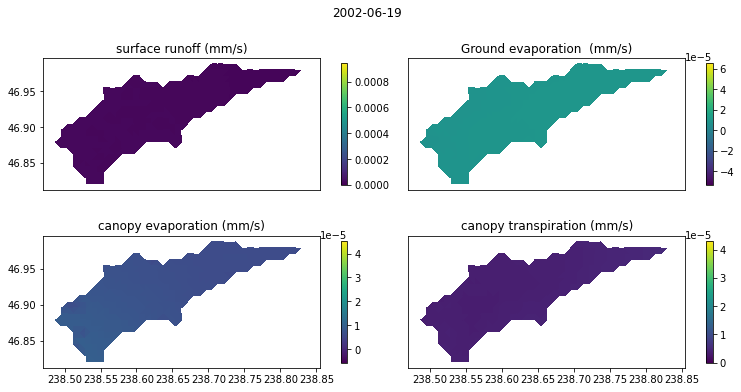

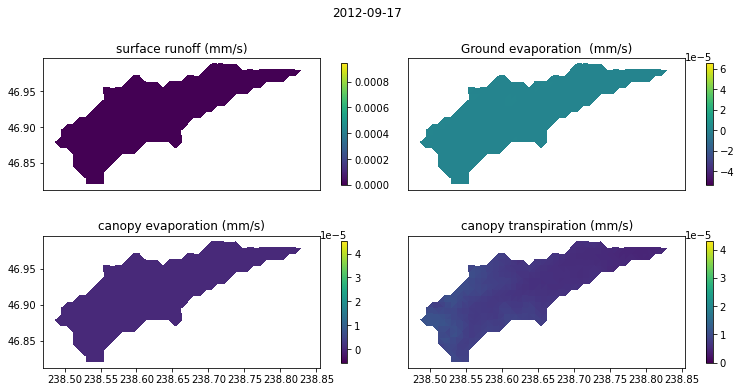

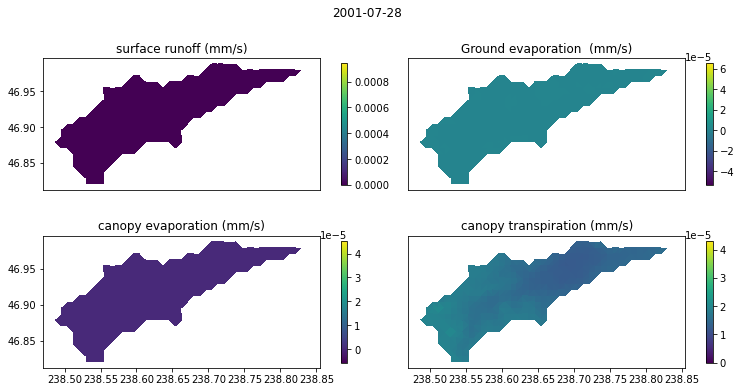

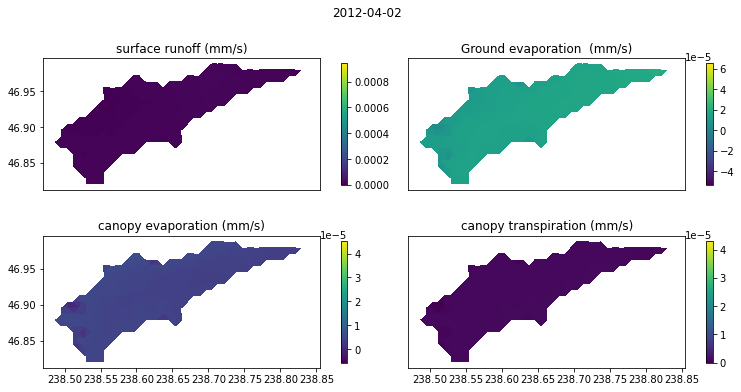

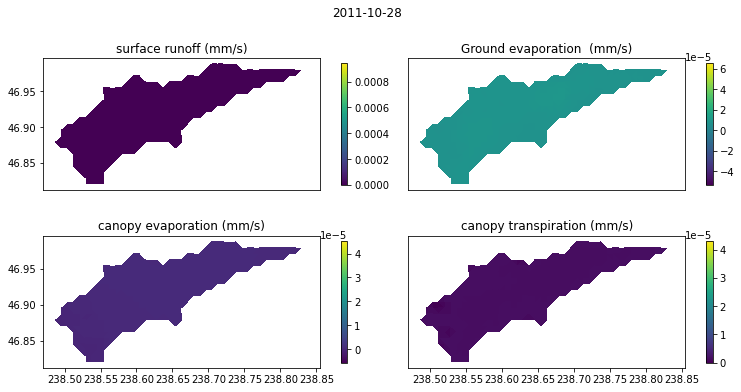

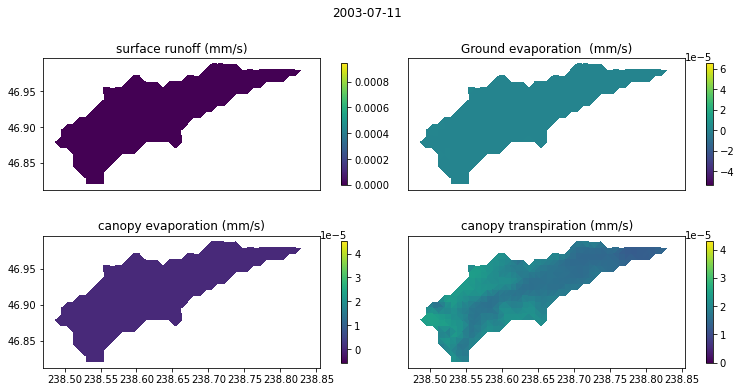

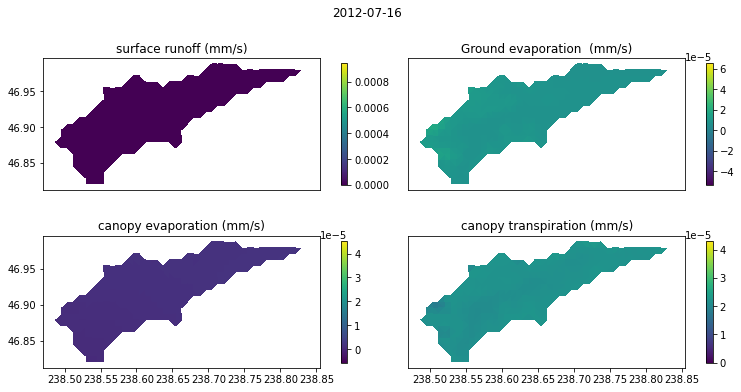

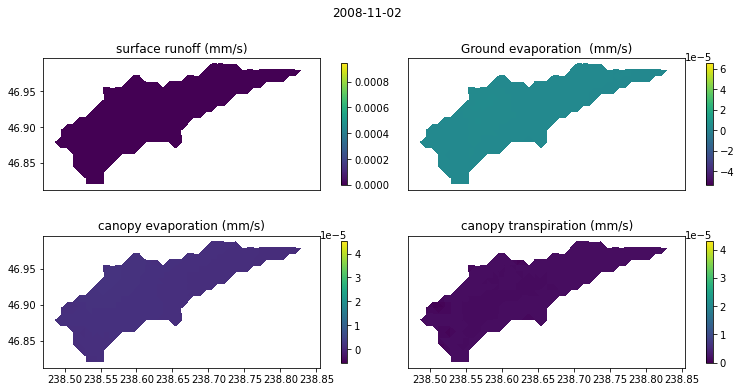

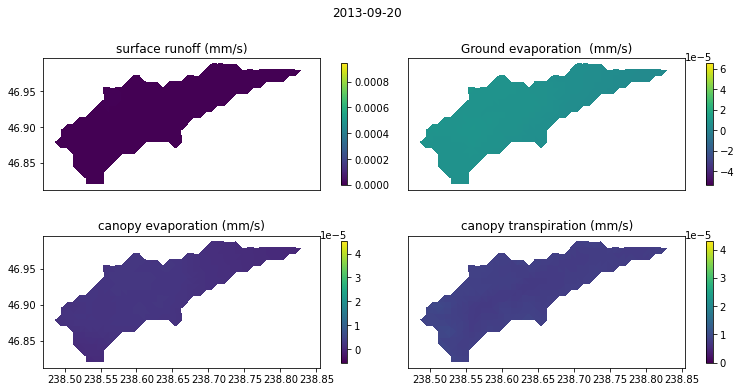

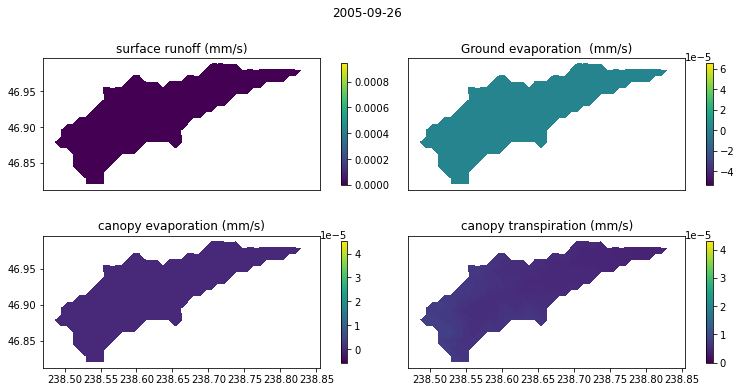

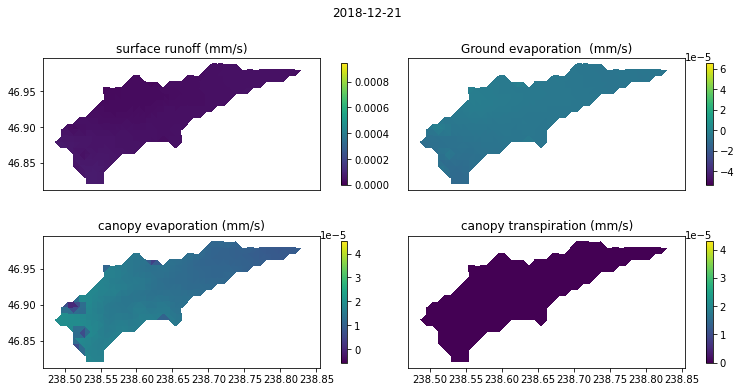

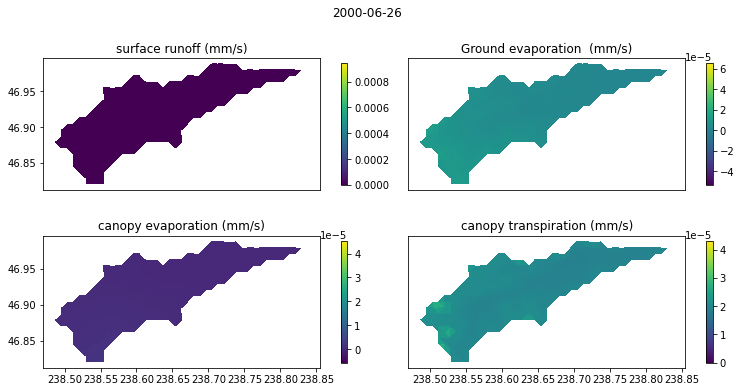

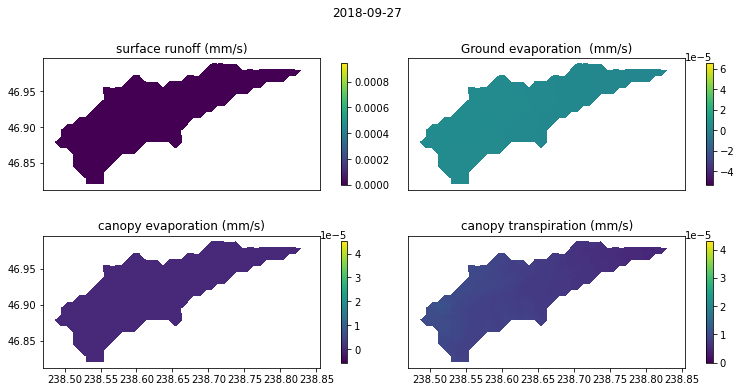

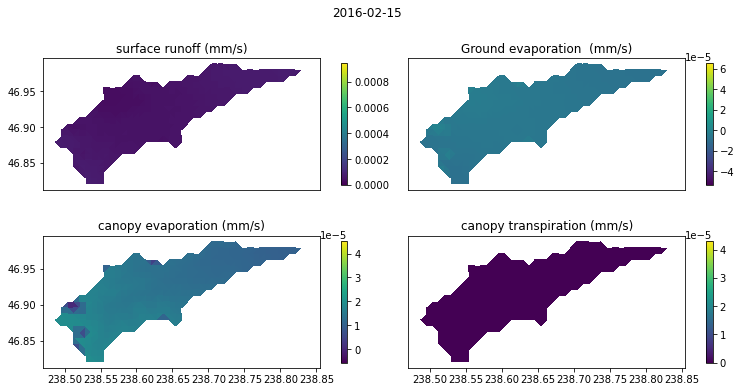

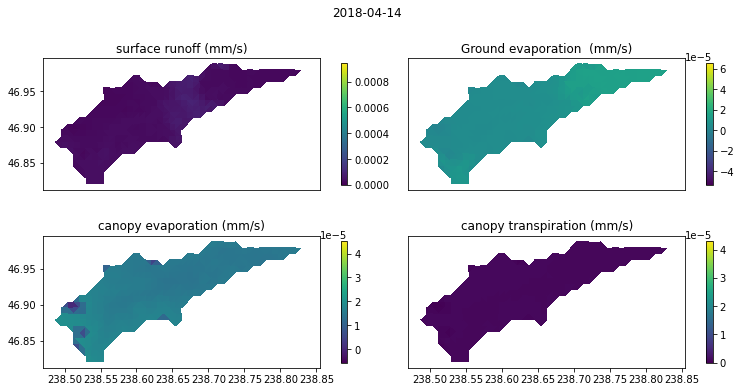

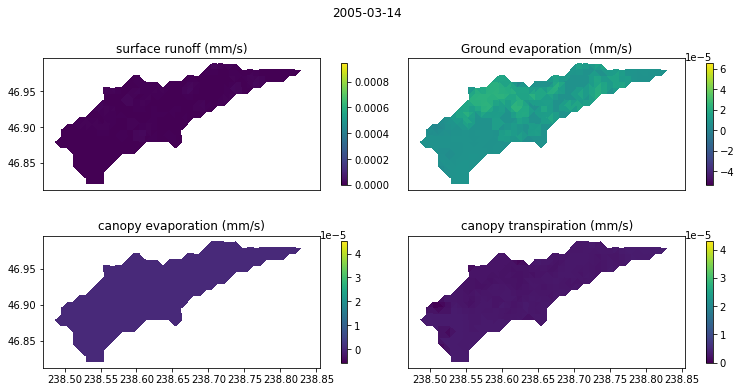

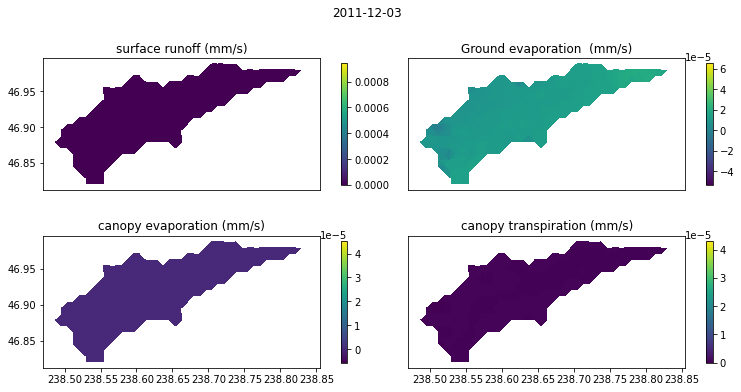

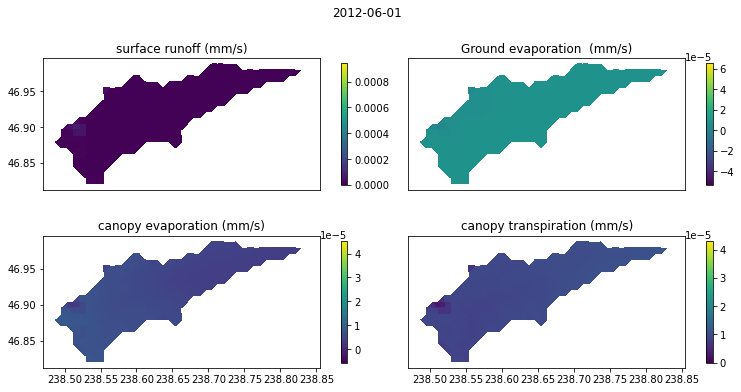

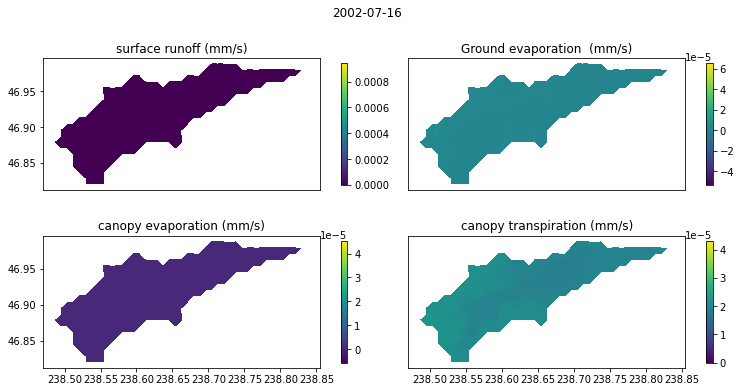

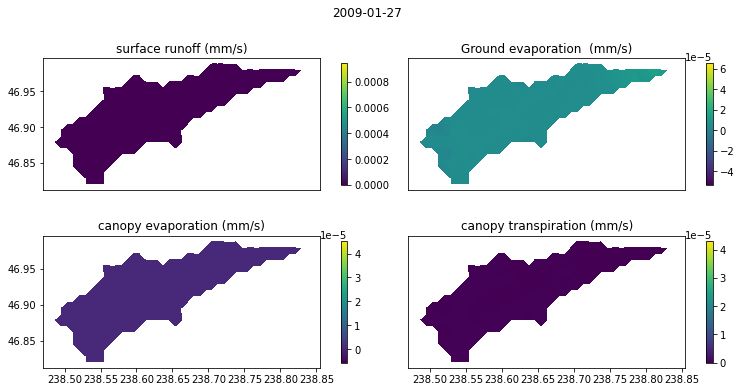

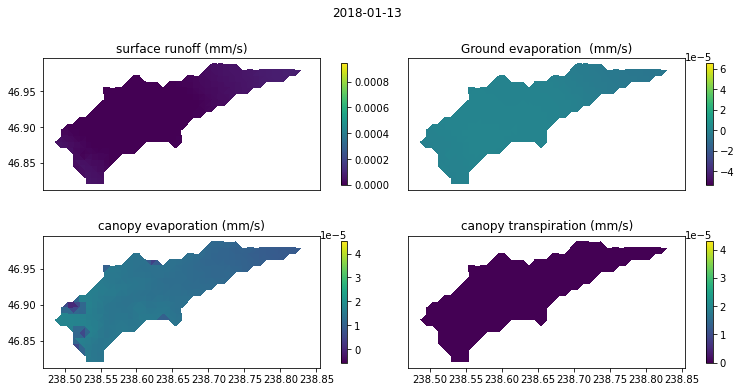

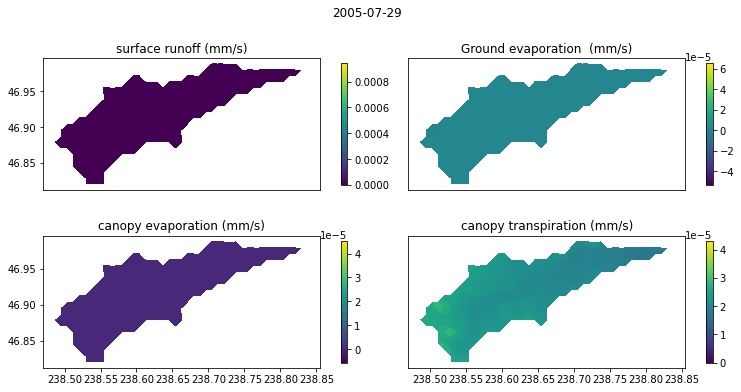

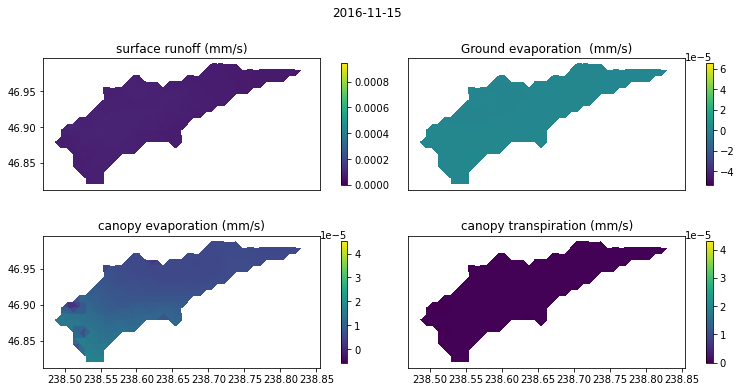

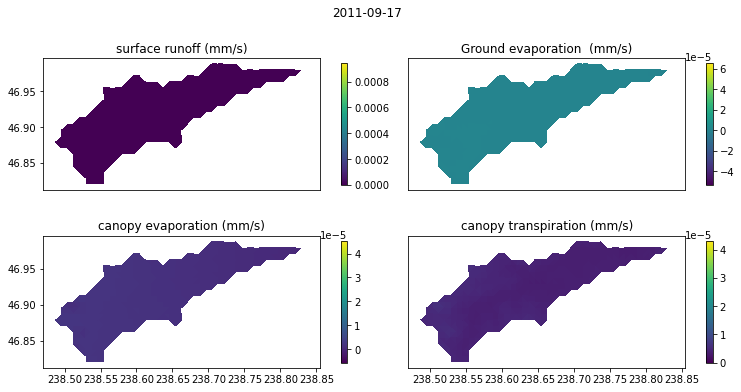

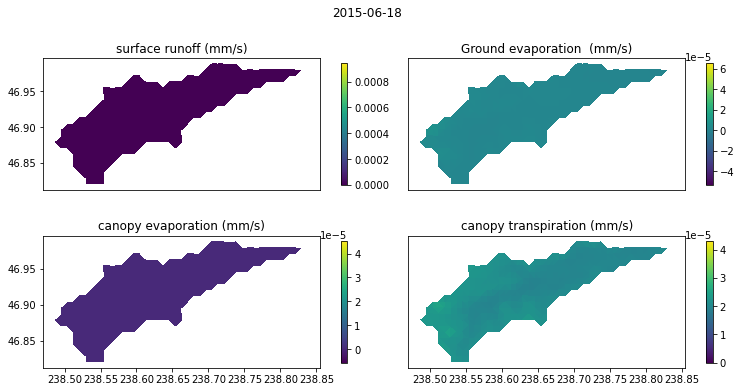

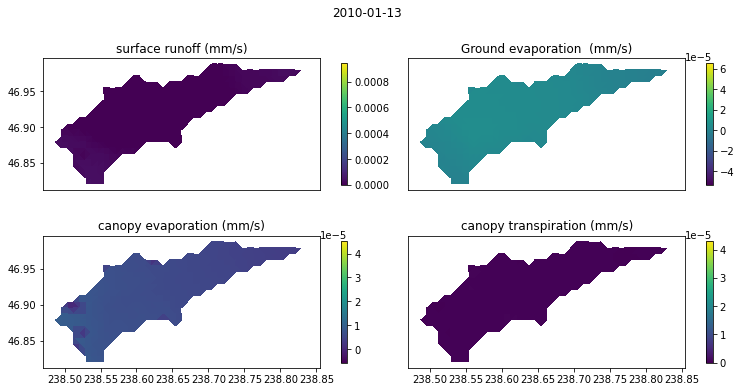

KeyboardInterrupt: 

In [13]:
varname1 = 'QOVER'
varname2 = 'QSOIL'
varname3 = 'QVEGE'
varname4 = 'QVEGT'

triang = tri.Triangulation(lon_elm_in,lat_elm_in)
dist_lons =[]
max_dist_lons=[]
dist_lats =[]
max_dist_lats=[]
for length in range(len(lon_elm_in[triang.triangles])):
    newlist = [abs(i-j) for i in lon_elm_in[triang.triangles][length] for j in lon_elm_in[triang.triangles][length] if i != j]
    dist_lons.append(list(set(newlist)))
    max_dist_lons.append(max(newlist))
for length in range(len(lat_elm_in[triang.triangles])):
    newlist = [abs(i-j) for i in lat_elm_in[triang.triangles][length] for j in lat_elm_in[triang.triangles][length] if i != j]
    # print(newlist)
    # print(list(set(newlist)))
    dist_lats.append(list(set(newlist)))
    max_dist_lats.append(max(newlist))

mask_indx=np.union1d(np.where(max_dist_lats>np.percentile(max_dist_lats,80)),np.where(max_dist_lons>np.percentile(max_dist_lons,80)))
mask = np.zeros(np.shape(triang.triangles)[0])
for i in range(np.shape(triang.triangles)[0]):
    if i in mask_indx:            
        mask[i]=1
    else:
        mask[i]=0
for f in nc_list:
    nc_elm = nc.Dataset(f)

    var_elm_in_1 = nc_elm.variables[varname1][0][grids_in_poly]
    var_elm_in_2 = nc_elm.variables[varname2][0][grids_in_poly]
    var_elm_in_3 = nc_elm.variables[varname3][0][grids_in_poly]
    var_elm_in_4 = nc_elm.variables[varname4][0][grids_in_poly]
       
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(ncols = 2,nrows = 2,figsize=(12,6))


    tcp1 = ax1.tripcolor(lon_elm_in,lat_elm_in,var_elm_in_1,mask=mask,alpha=1,vmin=var1_min_w,vmax=var1_max_w )
    fig.colorbar(tcp1,fraction=0.02,pad=.07,ax=ax1)
    ax1.set_aspect('equal')
    ax1.set_xticks([])
    ax1.set_title(nc_elm[varname1].long_name+' ('+nc_elm[varname1].units+')')

    tcp2 = ax2.tripcolor(lon_elm_in,lat_elm_in,var_elm_in_2,mask=mask,alpha=1,vmin=var2_min_w,vmax=var2_max_w )
    ax2.set_aspect('equal')
    fig.colorbar(tcp2,fraction=0.02,ax=ax2, pad=0.07)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_title(nc_elm[varname2].long_name[0:19]+' ('+nc_elm[varname2].units+')')

    tcp3 = ax3.tripcolor(lon_elm_in,lat_elm_in,var_elm_in_3,mask=mask,alpha=1,vmin=var3_min_w,vmax=var3_max_w )
    ax3.set_aspect('equal')
    fig.colorbar(tcp3,fraction=0.02,ax=ax3, pad=0.07)
    ax3.set_title(nc_elm[varname3].long_name+' ('+nc_elm[varname3].units+')')

    tcp4 = ax4.tripcolor(lon_elm_in,lat_elm_in,var_elm_in_4,mask=mask,alpha=1, vmin=var4_min_w,vmax=var4_max_w )
    ax4.set_aspect('equal')
    fig.colorbar(tcp4,fraction=0.02,ax=ax4, pad=0.07)
    ax4.set_title(nc_elm[varname4].long_name+' ('+nc_elm[varname4].units+')')
    ax4.set_yticks([])
    plt.suptitle(f.split('.')[-2][0:10])
    # plt.savefig('/global/cscratch1/sd/fzahura/e3sm_scratch/cori-knl/IELM.NLDAS.1175.NTASKS64.run.ARW/run/Images/'+f.split('.')[-2][0:10]+'.png',dpi=300)
    plt.show()

#### Plotting (time series, spatial average)

In [16]:
varname = ['QOVER','QSOIL','QVEGE','QVEGT']
Dates = []
nc_list = glob.glob('/pscratch/sd/f/fzahura/e3sm_scratch/pm-cpu/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P/run/I20TRCNPRDCTCBC.NLDAS.1175.NTASKS128.transient.daily.ARW.P.elm.h0.*.nc')

var_elm_in = [[],[],[],[]]
#get values of variables within the shapefile boundary
for f in nc_list:
    nc_elm = nc.Dataset(f)
    for i in range(len(varname)):
        var_elm_in[i].append( np.mean(nc_elm.variables[varname[i]][0][grids_in_poly]))
    # print(np.mean(nc_elm.variables[varname1][0][grids_in_poly]))
    # print(f.split('.')[-2][0:10])
    Dates.append(f.split('.')[-2][0:10])

In [17]:
print(len(Dates),len(var_elm_in[0]),len(var_elm_in[1]),len(var_elm_in[2]),len(var_elm_in[3]))

6936 6936 6936 6936 6936


In [18]:
# df_var = pd.DataFrame({'Date':Dates,'QOVER':var_elm_in_1})
df_var = pd.DataFrame({ 'QOVER': var_elm_in[0],'QSOIL':var_elm_in[1],'QVEGE':var_elm_in[2],'QVEGT':var_elm_in[3]}, index=pd.DatetimeIndex(Dates))

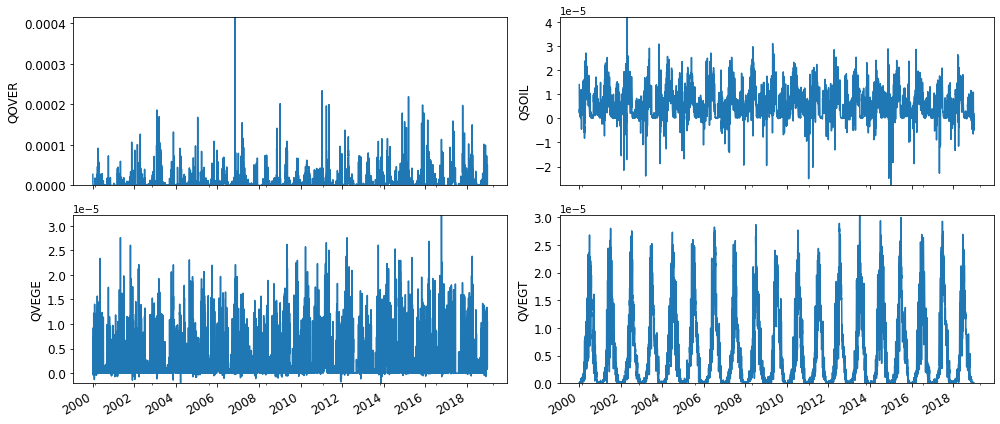

In [19]:
fig,((ax1,ax2),(ax3,ax4)) =plt.subplots(ncols = 2,nrows = 2,figsize=(14,6),sharex=True)

df_var.QOVER.plot(ax = ax1,fontsize=12)
ax1.set_ylim(df_var.QOVER.min(),df_var.QOVER.max())
ax1.set_ylabel(varname[0],fontsize=12)
df_var.QSOIL.plot(ax = ax2,fontsize=12)
ax2.set_ylim(df_var.QSOIL.min(),df_var.QSOIL.max())
ax2.set_ylabel(varname[1],fontsize=12)
df_var.QVEGE.plot(ax = ax3,fontsize=12)
ax3.set_ylim(df_var.QVEGE.min(),df_var.QVEGE.max())
ax3.set_ylabel(varname[2],fontsize=12)
df_var.QVEGT.plot(ax = ax4,fontsize=12)
ax4.set_ylim(df_var.QVEGT.min(),df_var.QVEGT.max())
ax4.set_ylabel(varname[3],fontsize=12)
plt.tight_layout()
# plt.savefig('/global/homes/f/fzahura/Plots/ELM_outputs/Trsient_runoff_ET.png',dpi=300)

### Plot Daymet

In [5]:
path = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/TILES_AmericanRiverWatershed/cpl_bypass_full/'

In [6]:
daymet = xr.open_dataset(path+'GSWP3_daymet4_PRECTmms_1980-2014_z01.nc')

In [7]:
daymet

<xarray.Dataset>
Dimensions:   (DTIME: 102200, n: 589)
Coordinates:
  * DTIME     (DTIME) datetime64[ns] 1980-01-01T03:00:00 ... 2014-12-23
Dimensions without coordinates: n
Data variables:
    LONGXY    (n) float32 ...
    LATIXY    (n) float32 ...
    PRECTmms  (n, DTIME) float64 ...

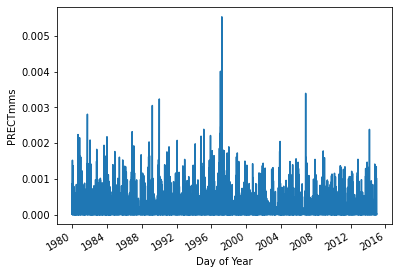

In [11]:
daymet['PRECTmms'][90].plot()